# Lecture 3: Attention in Machine Learning
## CSC5991 — Introduction to LLMs: "Attention Is All You Need"
### Companion Notebook (~59 Slides)

**Student Notes by:** Anik Tahabilder | **Email:** tahabilderanik@gmail.com

---

**What this notebook covers:**

| Section | Topic | Slides |
|---------|-------|--------|
| Part A | What is Attention? | 2-3 |
| Part B | Seq2Seq: RNNs + Attention (Machine Translation / NLP) | 4-13 |
| Part C | CNN Architecture from Scratch | 14-58 |
| Part D | Attention in CNNs / Connecting Attention to Vision | — |
| Part E | Summary & Self-Test | — |

> **Pre-requisites assumed:** Basic Python. That is it — every machine-learning
> concept is explained from scratch.
>
> **Dependencies:** Only `numpy` and `matplotlib`. No PyTorch or TensorFlow required.

---
# Part 0 — Environment Setup

Before we write any machine-learning code we need to import a few libraries.
Do not worry if you have never seen these before; we will explain each one as
we use it.

| Library | What it does (plain English) |
|---------|-----------------------------|
| `numpy` | A library for fast number-crunching on arrays (tables of numbers). All ML operations happen on arrays. |
| `matplotlib` | A plotting library — we use it to display images, graphs, and heatmaps. |

In [1]:
# ============================================================
# 0.  Imports
# ============================================================
import numpy as np                 # Numerical arrays
import matplotlib.pyplot as plt    # Plotting / visualization
import matplotlib.patches as patches  # For drawing shapes on plots

# Nicer plots inside the notebook
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8, 5)

# Reproducibility — same random numbers every time
np.random.seed(42)

print("All imports succeeded!")
print(f"NumPy version      : {np.__version__}")
print(f"Matplotlib imported : yes")
print()
print("We will use ONLY numpy and matplotlib in this notebook.")
print("Every ML operation is implemented from scratch for learning purposes.")

All imports succeeded!
NumPy version      : 2.4.2
Matplotlib imported : yes

We will use ONLY numpy and matplotlib in this notebook.
Every ML operation is implemented from scratch for learning purposes.


---
# Part A — What is Attention? (Slides 2-3)

## A.1  Context is Not New

Before "attention" became a buzzword in deep learning, machine learning models
were already designed to exploit **context** — information from nearby or related
data points.

| Model | Type of Context | How it Works |
|-------|----------------|--------------|
| **RNN** (Recurrent Neural Network) | **Temporal locality** | Processes sequences one step at a time, carrying a "memory" (hidden state) from previous steps |
| **CNN** (Convolutional Neural Network) | **Spatial locality** | Looks at small patches (filters) of an image at a time, capturing local patterns |

By designing these architectures, we **embed priors** into our models — we force
them to pay "attention" to certain types of features:

- RNNs pay attention to **sequential patterns** (what came before)
- CNNs pay attention to **spatial patterns** (what is nearby in an image)

### So what is new about "Attention"?

What we call **attention** in deep learning today is a *learned* mechanism that
allows the model to **dynamically decide** which parts of the input are most
relevant for the current task — rather than having this baked into the architecture.

> **Key insight:** Instead of forcing the model to process everything equally,
> we let it **learn where to look**.

This is especially useful in **sequence-to-sequence** modelling, where the input
and output can be different lengths and the relationship between positions is
complex.

### Real-World Analogy

Imagine you are reading a newspaper article to answer a specific question:

- **Without attention:** You read the entire article word-by-word, then try to
  answer from memory.
- **With attention:** You *scan* the article and *focus* on the paragraphs most
  relevant to the question. Your eyes spend more time on important sentences
  and skip over irrelevant ones.

That "focusing" is exactly what attention does in a neural network.

## A.2  What is a Learned Attention Mechanism?

A learned attention mechanism is a **function** that allows a model to attend to
different parts of the input content. It assigns **weights** (importance scores)
to different positions, and these weights are learned during training.

### Forms of Attention

| Form | Formula | Intuition |
|------|---------|-----------|
| **Additive** (Bahdanau, 2014) | $e_{t,i} = v^T \tanh(W_1 s_t + W_2 h_i)$ | Uses a small neural network to compute relevance |
| **Dot-Product** (Luong, 2015) | $e_{t,i} = s_t^T h_i$ | Simple dot product — if vectors point same direction, high score |
| **Scaled Dot-Product** (Vaswani, 2017) | $e_{t,i} = \frac{s_t^T h_i}{\sqrt{d_k}}$ | Dot product divided by sqrt of dimension to prevent large values |

### Names Based on What is Attended To

| Name | Also Called | What Happens | Example |
|------|-------------|-------------|---------|
| **Self-Attention** | Intra-attention | A sequence attends to **itself** | Each word in a sentence looks at every other word to understand context |
| **Cross-Attention** | Encoder-Decoder / Inter-attention | One sequence attends to **another** | Decoder attends to encoder outputs (e.g., in translation) |

```
Self-Attention:                    Cross-Attention:

  "The cat sat on the mat"           Encoder: "Le chat dort"
    |   |   |   |  |   |                    |     |     |
    +---+---+---+--+---+                    v     v     v
    Each word looks at                  Decoder: "The cat sleeps"
    ALL other words in                  looks at the encoder
    the SAME sentence                   (a DIFFERENT sequence)
```

## A.3  Simple Attention Demo — "Where to Look"

Let us start with a toy example. Imagine you have a sentence of 5 words, and
you want to know which words are most relevant to a **query** (a question you
are trying to answer).

Attention assigns a **weight** to each word. Higher weight = more relevant.

In [2]:
# ============================================================
# A.3  Toy example: "Where to look" with attention
# ============================================================

# Imagine a sentence: each word is represented by a random vector
sentence_words = ["The", "cat", "sat", "on", "mat"]
num_words = len(sentence_words)
dim = 4  # Each word is a vector of 4 numbers

# Word vectors (in a real system, these come from training)
word_vectors = np.random.randn(num_words, dim)

# A query: "What animal is mentioned?" — also a vector
query = np.random.randn(dim)

print("SENTENCE WORD VECTORS")
print("=" * 50)
for i, word in enumerate(sentence_words):
    print(f"  '{word:4s}' -> {word_vectors[i].round(2)}")
print()
print(f"QUERY vector -> {query.round(2)}")
print("(Represents: 'What animal is mentioned?')")
print()

# ----- STEP 1: Compute alignment scores (dot product) -----
scores = word_vectors @ query   # shape: (5,)
print("STEP 1: Alignment Scores (dot product of each word with query)")
print("-" * 50)
for i, word in enumerate(sentence_words):
    bar = "#" * int(max(0, scores[i]) * 5)
    print(f"  '{word:4s}' : score = {scores[i]:+.4f}  {bar}")

# ----- STEP 2: Softmax to get attention weights -----
def softmax(x):
    '''Compute softmax: exp(x_i) / sum(exp(x_j))'''
    e_x = np.exp(x - np.max(x))   # subtract max for numerical stability
    return e_x / e_x.sum()

weights = softmax(scores)

print()
print("STEP 2: Attention Weights (after softmax — sum to 1.0)")
print("-" * 50)
for i, word in enumerate(sentence_words):
    bar = "#" * int(weights[i] * 40)
    print(f"  '{word:4s}' : weight = {weights[i]:.4f}  {bar}")
print(f"  Sum = {weights.sum():.4f}")

# ----- STEP 3: Context vector (weighted sum) -----
context = weights @ word_vectors  # shape: (dim,)
print()
print("STEP 3: Context Vector (weighted sum of word vectors)")
print("-" * 50)
print(f"  context = {context.round(4)}")
print()
print("The context vector is a SUMMARY of the input that emphasises")
print(f"the most relevant word: '{sentence_words[np.argmax(weights)]}'")
print(f"(which received {weights.max()*100:.1f}% of the attention)")

SENTENCE WORD VECTORS
  'The ' -> [ 0.5  -0.14  0.65  1.52]
  'cat ' -> [-0.23 -0.23  1.58  0.77]
  'sat ' -> [-0.47  0.54 -0.46 -0.47]
  'on  ' -> [ 0.24 -1.91 -1.72 -0.56]
  'mat ' -> [-1.01  0.31 -0.91 -1.41]

QUERY vector -> [ 1.47 -0.23  0.07 -1.42]
(Represents: 'What animal is mentioned?')

STEP 1: Alignment Scores (dot product of each word with query)
--------------------------------------------------
  'The ' : score = -1.3670  
  'cat ' : score = -1.2771  
  'sat ' : score = -0.1783  
  'on  ' : score = +1.4712  #######
  'mat ' : score = +0.3955  #

STEP 2: Attention Weights (after softmax — sum to 1.0)
--------------------------------------------------
  'The ' : weight = 0.0354  #
  'cat ' : weight = 0.0387  #
  'sat ' : weight = 0.1160  ####
  'on  ' : weight = 0.6040  ########################
  'mat ' : weight = 0.2060  ########
  Sum = 1.0000

STEP 3: Context Vector (weighted sum of word vectors)
--------------------------------------------------
  context = [-0.1085 -1.

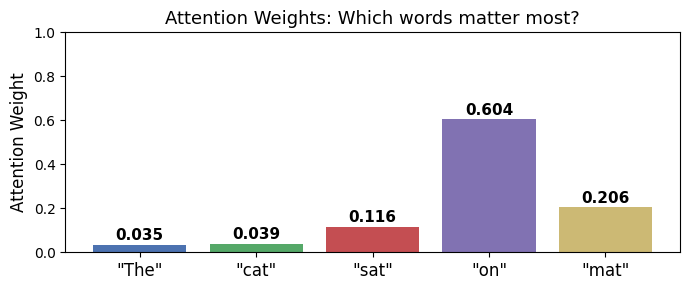

The tallest bar shows where the model 'focuses' the most.


In [3]:
# ============================================================
# Visualise the attention weights
# ============================================================

fig, ax = plt.subplots(figsize=(7, 3))
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]
bars = ax.bar(range(num_words), weights, color=colors)
ax.set_xticks(range(num_words))
ax.set_xticklabels([f'"{w}"' for w in sentence_words], fontsize=12)
ax.set_ylabel("Attention Weight", fontsize=12)
ax.set_title("Attention Weights: Which words matter most?", fontsize=13)
ax.set_ylim(0, 1)
for i, w in enumerate(weights):
    ax.text(i, w + 0.02, f"{w:.3f}", ha="center", fontsize=11, fontweight="bold")
plt.tight_layout()
plt.show()
print("The tallest bar shows where the model 'focuses' the most.")

---
# Part B — Seq2Seq: RNNs + Attention (Slides 4-13)

## B.1  The Seq2Seq Framework

**Seq2Seq** (Sequence-to-Sequence) is a family of models that convert one
sequence into another. This is incredibly versatile:

| Input | Output | Task |
|-------|--------|------|
| Text (English) | Text (French) | Machine Translation |
| Question + Context | Answer | Question Answering |
| Long text | Short text | Summarisation |
| Image (pixels) | Text (caption) | Image Captioning |
| Speech (audio) | Text | Speech Recognition |

### The Encoder-Decoder Architecture

A Seq2Seq model has two main parts:

```
                 ENCODER                         DECODER
            ┌──────────────┐               ┌──────────────┐
            │              │               │              │
 Input  ──> │   Reads the  │ ── context ─> │  Generates   │ ──> Output
 Sequence   │   entire     │    vector     │  output one  │     Sequence
            │   input      │               │  step at a   │
            │              │               │  time        │
            └──────────────┘               └──────────────┘
```

Both the encoder and decoder are typically **RNNs** (Recurrent Neural Networks)
or, more recently, **Transformers**.

### How an RNN Works (Quick Primer)

An RNN processes a sequence one element at a time. At each step, it:
1. Takes the current input $x_t$
2. Combines it with its previous "memory" (hidden state $h_{t-1}$)
3. Produces a new hidden state $h_t$

$$h_t = f(x_t, h_{t-1})$$

Think of it like reading a book word by word — your understanding of the story
(hidden state) updates with each new word you read.

```
 x_1         x_2         x_3         x_4
  |           |           |           |
  v           v           v           v
┌─────┐    ┌─────┐    ┌─────┐    ┌─────┐
│ RNN │───>│ RNN │───>│ RNN │───>│ RNN │
│cell │    │cell │    │cell │    │cell │
└─────┘    └─────┘    └─────┘    └─────┘
  |           |           |           |
  v           v           v           v
 h_1         h_2         h_3         h_4
```

## B.2  The Fixed Context Bottleneck Problem

In the basic Seq2Seq model:

- The **encoder** reads the entire input and produces a sequence of hidden states
  $h_1, h_2, \ldots, h_T$
- Only the **last** hidden state $h_T$ is used as the **context vector** $c$
- The **decoder** uses this single vector $c$ to generate the entire output:
  $s_t = g(y_{t-1}, s_{t-1}, c)$

```
ENCODER:
  "I"    "love"   "machine"  "learning"
   |       |         |          |
   v       v         v          v
 [RNN] → [RNN] →  [RNN]  →  [RNN]
   |       |         |          |
  h_1     h_2       h_3        h_4
                                |
                                v
                          context c = h_4  <--- ALL info squeezed here!
                                |
                     ┌──────────┘
                     v
DECODER:           [RNN] → [RNN] → [RNN] → [RNN]
                     |        |       |        |
                   "J'"   "adore"   "le"   "ML"
```

### Why This is a Problem

> *"You can't cram the meaning of a whole %$&@ sentence into a single
> fixed-size vector!"*
> — Ray Mooney (famous NLP researcher)

The context vector $c$ has a **fixed size** (e.g., 256 or 512 numbers). It must
somehow encode the meaning of the ENTIRE input sequence. For long inputs, this
is like trying to summarise a whole book on a sticky note.

| Input Length | Quality with Fixed Context |
|-------------|---------------------------|
| 5-10 words | Good — manageable amount of info |
| 20-30 words | Mediocre — starts losing details |
| 50+ words | Poor — too much information lost |

This is the **bottleneck problem**.

In [4]:
# ============================================================
# B.2  Demonstrate the bottleneck problem
# ============================================================

print("DEMONSTRATING THE BOTTLENECK PROBLEM")
print("=" * 60)
print()

# Simulate: can a fixed-size vector faithfully represent sequences
# of different lengths?

context_size = 8  # Our "bottleneck" vector has only 8 numbers

for seq_len in [3, 10, 30, 100]:
    # Generate a random sequence
    sequence = np.random.randn(seq_len, context_size)

    # Simulate the encoder: just take the last hidden state
    # (in reality the RNN would process each step, but the point
    #  is that we compress everything into one vector)
    context = sequence[-1]  # Only the last state

    # How much information did we lose?
    # A rough measure: what fraction of total variation is captured?
    total_info = np.sum(np.var(sequence, axis=0))
    context_info = np.sum(context**2)
    ratio = min(context_info / (total_info + 1e-8), 1.0)

    bar = "#" * int(ratio * 30)
    print(f"  Sequence length {seq_len:>3d}: info retained ~ {ratio*100:5.1f}%  {bar}")

print()
print("As the sequence gets longer, the single context vector")
print("retains a smaller fraction of the total information.")
print("This is the BOTTLENECK problem!")

DEMONSTRATING THE BOTTLENECK PROBLEM

  Sequence length   3: info retained ~ 100.0%  ##############################
  Sequence length  10: info retained ~ 100.0%  ##############################
  Sequence length  30: info retained ~  50.3%  ###############
  Sequence length 100: info retained ~ 100.0%  ##############################

As the sequence gets longer, the single context vector
retains a smaller fraction of the total information.
This is the BOTTLENECK problem!


## B.3  Attention to the Rescue!

### The Solution: Dynamic Context Vectors

Instead of using a SINGLE context vector for all decoder steps, we use a
**DIFFERENT** context vector $c_t$ for each decoder timestep $t$:

$$s_t = g(y_{t-1}, s_{t-1}, c_t) \quad\text{(no more bottleneck!)}$$

Each $c_t$ is computed by **attending** to ALL encoder hidden states:

```
ENCODER:
  "I"    "love"   "machine"  "learning"
   |       |         |          |
   v       v         v          v
 [RNN] → [RNN] →  [RNN]  →  [RNN]
   |       |         |          |
  h_1     h_2       h_3        h_4
   |       |         |          |
   +-------+---------+----------+----> ALL states available!
                                       |
                    ┌──────────────────┘
                    v
               [ATTENTION]  <--- computes different c_t at each step
                    |
                    v
DECODER:  c_1     c_2       c_3      c_4
           |       |         |        |
         [RNN] → [RNN] →  [RNN]  → [RNN]
           |       |         |        |
         "J'"  "adore"  "l'apprentissage"  "automatique"
```

### How Attention Computes $c_t$ (Three Steps)

**Step 1: Alignment scores** — How relevant is encoder position $i$ for
decoder step $t$?

$$e_{t,i} = f_{att}(s_{t-1}, h_i)$$

**Step 2: Attention weights** — Normalise scores to sum to 1 (softmax):

$$\alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_{j=1}^{T} \exp(e_{t,j})}$$

**Step 3: Context vector** — Weighted sum of encoder states:

$$c_t = \sum_{i=1}^{T} \alpha_{t,i} \cdot h_i$$

### Interpretation

$\alpha_{t,i}$ represents the **probability** that target word $y_t$ is
**aligned to** (most related to) source word $x_i$.

### Bi-directional Encoder

The encoder is typically **bi-directional**: it reads the input both
forward and backward. This means each hidden state $h_i$ contains
information about BOTH the preceding AND following words, giving
the attention mechanism richer representations to work with.

### Everything is Differentiable

All the steps above (dot products, softmax, weighted sum) are
**differentiable** — meaning we can compute gradients and train the
attention weights using standard backpropagation. The model LEARNS
where to attend!

## B.4  Attention Computation — Step by Step in Code

Let us implement attention from scratch with numpy, using tiny toy numbers
so you can follow every computation.

In [5]:
# ============================================================
# B.4  Step-by-step attention computation with numpy
# ============================================================

# ----- Setup: Encoder and Decoder states -----
# Imagine we have a 5-word source sentence encoded by an RNN.
# Each encoder hidden state is a vector of size 6.

source_words = ["I", "love", "machine", "learning", "!"]
seq_len = len(source_words)
hidden_dim = 6

# Encoder hidden states (one per source word)
# In reality, these come from running an RNN over the source sentence.
np.random.seed(42)
encoder_states = np.random.randn(seq_len, hidden_dim)

# Current decoder hidden state
# (what the decoder is "thinking" at the current timestep)
decoder_state = np.random.randn(hidden_dim)

print("ENCODER HIDDEN STATES (one per source word)")
print("=" * 60)
for i, word in enumerate(source_words):
    vals = ", ".join([f"{v:+.2f}" for v in encoder_states[i]])
    print(f"  h[{i}] ({word:>10s}) = [{vals}]")
print()
print("DECODER STATE (what the decoder is 'thinking' now)")
vals = ", ".join([f"{v:+.2f}" for v in decoder_state])
print(f"  s = [{vals}]")

ENCODER HIDDEN STATES (one per source word)
  h[0] (         I) = [+0.50, -0.14, +0.65, +1.52, -0.23, -0.23]
  h[1] (      love) = [+1.58, +0.77, -0.47, +0.54, -0.46, -0.47]
  h[2] (   machine) = [+0.24, -1.91, -1.72, -0.56, -1.01, +0.31]
  h[3] (  learning) = [-0.91, -1.41, +1.47, -0.23, +0.07, -1.42]
  h[4] (         !) = [-0.54, +0.11, -1.15, +0.38, -0.60, -0.29]

DECODER STATE (what the decoder is 'thinking' now)
  s = [-0.60, +1.85, -0.01, -1.06, +0.82, -1.22]


In [6]:
# ============================================================
# STEP 1: Alignment scores (dot-product attention)
# ============================================================
# For each encoder position i, compute:
#   score_i = decoder_state . encoder_states[i]   (dot product)
#
# The dot product measures similarity:
#   - Large positive: vectors point in similar direction (relevant!)
#   - Near zero: vectors are unrelated
#   - Large negative: vectors point in opposite directions

scores = encoder_states @ decoder_state   # shape: (5,)

print("STEP 1: Alignment Scores (dot products)")
print("=" * 60)
print()

# Show the computation for one position in detail
i = 0
print(f"  Detailed computation for position 0 ('{source_words[0]}'):")
terms = []
total = 0.0
for j in range(hidden_dim):
    product = encoder_states[i][j] * decoder_state[j]
    total += product
    terms.append(f"({encoder_states[i][j]:+.2f})*({decoder_state[j]:+.2f})={product:+.4f}")
print(f"    {' + '.join(terms[:3])}")
print(f"    + {' + '.join(terms[3:])}")
print(f"    = {total:+.4f}  (matches score[0] = {scores[0]:+.4f})")
print()

# Show all scores
print("  All alignment scores:")
for i, word in enumerate(source_words):
    bar = "#" * int(max(0, (scores[i] + 3)) * 4)
    print(f"    score[{i}] ({word:>10s}) = {scores[i]:+.4f}  {bar}")

STEP 1: Alignment Scores (dot products)

  Detailed computation for position 0 ('I'):
    (+0.50)*(-0.60)=-0.2989 + (-0.14)*(+1.85)=-0.2561 + (+0.65)*(-0.01)=-0.0087
    + (+1.52)*(-1.06)=-1.6109 + (-0.23)*(+0.82)=-0.1926 + (-0.23)*(-1.22)=+0.2858
    = -2.0814  (matches score[0] = -2.0814)

  All alignment scores:
    score[0] (         I) = -2.0814  ###
    score[1] (      love) = +0.0911  ############
    score[2] (   machine) = -4.2882  
    score[3] (  learning) = -0.0557  ###########
    score[4] (         !) = +0.0132  ############


In [7]:
# ============================================================
# STEP 2: Attention weights (softmax)
# ============================================================
# Softmax converts raw scores into probabilities (0 to 1, sum to 1).
#
# Formula:  weight_i = exp(score_i) / sum(exp(score_j) for all j)

# First, let's compute it manually to understand
print("STEP 2: Attention Weights (softmax)")
print("=" * 60)
print()

# Numerical stability trick: subtract max before exp
max_score = np.max(scores)
print(f"  Subtract max score ({max_score:.4f}) for numerical stability:")
shifted = scores - max_score
for i, word in enumerate(source_words):
    print(f"    shifted[{i}] = {scores[i]:+.4f} - {max_score:.4f} = {shifted[i]:+.4f}")

print()
exp_scores = np.exp(shifted)
print(f"  Apply exp() to each:")
for i, word in enumerate(source_words):
    print(f"    exp({shifted[i]:+.4f}) = {exp_scores[i]:.4f}")

print()
total = exp_scores.sum()
print(f"  Sum of exponentials = {total:.4f}")
print()

weights = exp_scores / total
print(f"  Divide each by the sum to get weights:")
for i, word in enumerate(source_words):
    bar = "#" * int(weights[i] * 40)
    print(f"    alpha[{i}] ({word:>10s}) = {exp_scores[i]:.4f} / {total:.4f} = {weights[i]:.4f}  {bar}")

print()
print(f"  Sum of weights = {weights.sum():.4f}  (always 1.0!)")
print()
print(f"  The decoder pays {weights.max()*100:.1f}% of its attention to")
print(f"  '{source_words[np.argmax(weights)]}' (position {np.argmax(weights)})")

STEP 2: Attention Weights (softmax)

  Subtract max score (0.0911) for numerical stability:
    shifted[0] = -2.0814 - 0.0911 = -2.1726
    shifted[1] = +0.0911 - 0.0911 = +0.0000
    shifted[2] = -4.2882 - 0.0911 = -4.3794
    shifted[3] = -0.0557 - 0.0911 = -0.1468
    shifted[4] = +0.0132 - 0.0911 = -0.0779

  Apply exp() to each:
    exp(-2.1726) = 0.1139
    exp(+0.0000) = 1.0000
    exp(-4.3794) = 0.0125
    exp(-0.1468) = 0.8635
    exp(-0.0779) = 0.9250

  Sum of exponentials = 2.9149

  Divide each by the sum to get weights:
    alpha[0] (         I) = 0.1139 / 2.9149 = 0.0391  #
    alpha[1] (      love) = 1.0000 / 2.9149 = 0.3431  #############
    alpha[2] (   machine) = 0.0125 / 2.9149 = 0.0043  
    alpha[3] (  learning) = 0.8635 / 2.9149 = 0.2962  ###########
    alpha[4] (         !) = 0.9250 / 2.9149 = 0.3173  ############

  Sum of weights = 1.0000  (always 1.0!)

  The decoder pays 34.3% of its attention to
  'love' (position 1)


In [8]:
# ============================================================
# STEP 3: Context vector (weighted sum)
# ============================================================
# context = alpha[0]*h[0] + alpha[1]*h[1] + ... + alpha[4]*h[4]
#
# This produces a single vector that SUMMARISES the input,
# with emphasis on the most relevant parts.

print("STEP 3: Context Vector (weighted sum of encoder states)")
print("=" * 60)
print()

context = np.zeros(hidden_dim)
for i in range(seq_len):
    contribution = weights[i] * encoder_states[i]
    context += contribution
    print(f"  {weights[i]:.4f} * h[{i}] ({source_words[i]:>10s}) = [{', '.join([f'{v:+.4f}' for v in contribution])}]")

print(f"  {'─' * 55}")
print(f"  context vector = [{', '.join([f'{v:+.4f}' for v in context])}]")
print()
print("This context vector c_t is fed to the decoder along with the")
print("previous word to predict the next word in the translation.")
print()
print("KEY INSIGHT: At the next decoder timestep, a DIFFERENT context")
print("vector c_{t+1} will be computed with DIFFERENT weights, allowing")
print("the decoder to 'look at' different source words as needed!")

STEP 3: Context Vector (weighted sum of encoder states)

  0.0391 * h[0] (         I) = [+0.0194, -0.0054, +0.0253, +0.0595, -0.0091, -0.0091]
  0.3431 * h[1] (      love) = [+0.5418, +0.2633, -0.1611, +0.1861, -0.1590, -0.1598]
  0.0043 * h[2] (   machine) = [+0.0010, -0.0082, -0.0074, -0.0024, -0.0044, +0.0014]
  0.2962 * h[3] (  learning) = [-0.2690, -0.4184, +0.4342, -0.0669, +0.0200, -0.4220]
  0.3173 * h[4] (         !) = [-0.1728, +0.0352, -0.3653, +0.1192, -0.1906, -0.0926]
  ───────────────────────────────────────────────────────
  context vector = [+0.1205, -0.1335, -0.0743, +0.2956, -0.3431, -0.6822]

This context vector c_t is fed to the decoder along with the
previous word to predict the next word in the translation.

KEY INSIGHT: At the next decoder timestep, a DIFFERENT context
vector c_{t+1} will be computed with DIFFERENT weights, allowing
the decoder to 'look at' different source words as needed!


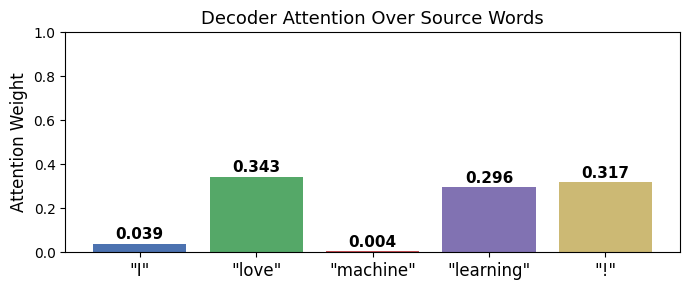

The tallest bar indicates which source word the decoder
is 'focusing on' when generating the current target word.


In [9]:
# ============================================================
# Visualize attention weights as a bar chart
# ============================================================

fig, ax = plt.subplots(figsize=(7, 3))
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]
bars = ax.bar(range(seq_len), weights, color=colors)
ax.set_xticks(range(seq_len))
ax.set_xticklabels([f'"{w}"' for w in source_words], fontsize=12)
ax.set_ylabel("Attention Weight", fontsize=12)
ax.set_title("Decoder Attention Over Source Words", fontsize=13)
ax.set_ylim(0, 1)
for i, w in enumerate(weights):
    ax.text(i, w + 0.02, f"{w:.3f}", ha="center", fontsize=11, fontweight="bold")
plt.tight_layout()
plt.show()

print("The tallest bar indicates which source word the decoder")
print("is 'focusing on' when generating the current target word.")

## B.5  Bahdanau (Additive) Attention — Full Implementation

The **Bahdanau attention** (also called **additive attention**) uses a small
neural network to compute alignment scores. This was the FIRST attention
mechanism proposed for neural machine translation (Bahdanau et al., 2014).

### The Formula

$$e_{t,i} = v^T \tanh(W_1 \cdot s_{t-1} + W_2 \cdot h_i)$$

Where:
- $s_{t-1}$ is the decoder's previous hidden state (query)
- $h_i$ is the encoder's hidden state at position $i$ (key)
- $W_1$, $W_2$ are learnable weight matrices
- $v$ is a learnable weight vector
- $\tanh$ is the hyperbolic tangent activation function

Let us implement this entirely from scratch with numpy.

In [10]:
# ============================================================
# B.5  Bahdanau Attention — from scratch with numpy
# ============================================================

class BahdanauAttentionNumpy:
    '''
    Additive (Bahdanau) attention implemented with pure numpy.

    score = v^T * tanh(W1 * decoder_state + W2 * encoder_state)

    All weights are randomly initialised (in a real system they
    would be learned through training).
    '''
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        # Learnable parameters (randomly initialised)
        scale = 0.1  # Small init for stability
        self.W1 = np.random.randn(decoder_dim, attention_dim) * scale
        self.W2 = np.random.randn(encoder_dim, attention_dim) * scale
        self.v  = np.random.randn(attention_dim) * scale

    def __call__(self, encoder_states, decoder_state):
        '''
        Args:
            encoder_states : (seq_len, encoder_dim) — all encoder hidden states
            decoder_state  : (decoder_dim,) — current decoder hidden state
        Returns:
            context : (encoder_dim,) — weighted sum of encoder states
            weights : (seq_len,) — attention weights (sum to 1)
        '''
        # Step 1: Project decoder state -> (attention_dim,)
        dec_proj = decoder_state @ self.W1   # (attention_dim,)

        # Step 2: Project each encoder state -> (seq_len, attention_dim)
        enc_proj = encoder_states @ self.W2  # (seq_len, attention_dim)

        # Step 3: Combine with tanh
        # dec_proj is broadcast: (attention_dim,) + (seq_len, attention_dim)
        combined = np.tanh(dec_proj + enc_proj)  # (seq_len, attention_dim)

        # Step 4: Score = v^T * combined -> (seq_len,)
        scores = combined @ self.v  # (seq_len,)

        # Step 5: Softmax
        exp_scores = np.exp(scores - np.max(scores))
        weights = exp_scores / exp_scores.sum()

        # Step 6: Context vector
        context = weights @ encoder_states  # (encoder_dim,)

        return context, weights


# ----- Test it -----
encoder_dim = 6
decoder_dim = 6
attention_dim = 8

attn = BahdanauAttentionNumpy(encoder_dim, decoder_dim, attention_dim)

# Reuse our encoder states and decoder state from before
context, att_weights = attn(encoder_states, decoder_state)

print("BAHDANAU (ADDITIVE) ATTENTION — From Scratch")
print("=" * 60)
print()
print(f"Encoder states shape : ({seq_len}, {encoder_dim})")
print(f"Decoder state shape  : ({decoder_dim},)")
print(f"Attention dim        : {attention_dim}")
print()
print("Attention weights:")
for i, word in enumerate(source_words):
    bar = "#" * int(att_weights[i] * 40)
    print(f"  alpha[{i}] ({word:>10s}) = {att_weights[i]:.4f}  {bar}")
print(f"  Sum = {att_weights.sum():.4f}")
print()
print(f"Context vector: [{', '.join([f'{v:+.4f}' for v in context])}]")
print()
print("Notice: The weights are DIFFERENT from dot-product attention")
print("because Bahdanau uses a learned neural network to compute scores,")
print("not just a simple dot product.")

BAHDANAU (ADDITIVE) ATTENTION — From Scratch

Encoder states shape : (5, 6)
Decoder state shape  : (6,)
Attention dim        : 8

Attention weights:
  alpha[0] (         I) = 0.2031  ########
  alpha[1] (      love) = 0.1954  #######
  alpha[2] (   machine) = 0.1929  #######
  alpha[3] (  learning) = 0.2121  ########
  alpha[4] (         !) = 0.1965  #######
  Sum = 1.0000

Context vector: [+0.1565, -0.5251, -0.2082, +0.3328, -0.4372, -0.4374]

Notice: The weights are DIFFERENT from dot-product attention
because Bahdanau uses a learned neural network to compute scores,
not just a simple dot product.


## B.6  Attention Map Visualization

In machine translation, we can visualize the attention weights as a 2D heatmap
where:
- **Rows** = target (output) words
- **Columns** = source (input) words
- **Color intensity** = attention weight $\alpha_{t,i}$

This creates an **attention map** (also called an alignment matrix).

### What to look for:

| Pattern | Meaning |
|---------|---------|
| Diagonal line | Words align in order (monotonic alignment) |
| Off-diagonal blocks | Word reordering (e.g., adjective-noun order differs between languages) |
| Spread-out rows | A target word depends on multiple source words |
| Focused rows | A target word depends on one specific source word |

In [11]:
# ============================================================
# B.6  Simulate a French-English translation attention map
# ============================================================

# English to French translation
english_words = ["The", "agreement", "on", "the", "European", "Economic", "Area"]
french_words  = ["L'", "accord", "sur", "la", "zone", "economique", "europeenne"]

# Simulate attention weights for each French word
# (In a real model, these would be learned)
# We'll create plausible alignment patterns
n_en = len(english_words)
n_fr = len(french_words)

# Create a plausible attention matrix
attention_matrix = np.zeros((n_fr, n_en))

# "L'"     -> "The"
attention_matrix[0] = softmax(np.array([3.0, 0.5, -1, -1, -1, -1, -1]))
# "accord" -> "agreement"
attention_matrix[1] = softmax(np.array([-1, 3.0, -1, -1, -1, -1, -1]))
# "sur"    -> "on"
attention_matrix[2] = softmax(np.array([-1, -1, 3.0, -1, -1, -1, -1]))
# "la"     -> "the"
attention_matrix[3] = softmax(np.array([-1, -1, -1, 3.0, -1, -1, -1]))
# "zone"   -> "Area" (reordering!)
attention_matrix[4] = softmax(np.array([-1, -1, -1, -1, -1, 0.5, 3.0]))
# "economique" -> "Economic" (reordering!)
attention_matrix[5] = softmax(np.array([-1, -1, -1, -1, -1, 3.0, 0.5]))
# "europeenne" -> "European" (reordering!)
attention_matrix[6] = softmax(np.array([-1, -1, -1, -1, 3.0, 0.5, -1]))

print("SIMULATED ATTENTION MAP: English -> French Translation")
print("=" * 60)
print()
print("English: " + " | ".join(english_words))
print("French:  " + " | ".join(french_words))
print()

# Print as ASCII heatmap
print("Attention matrix (French x English):")
header = "              " + "  ".join([f"{w:>10s}" for w in english_words])
print(header)
for i, fw in enumerate(french_words):
    row = f"  {fw:>12s} "
    for j in range(n_en):
        val = attention_matrix[i][j]
        if val > 0.5:
            row += "  ########## "
        elif val > 0.2:
            row += "  ######     "
        elif val > 0.1:
            row += "  ###        "
        else:
            row += "  .          "
    print(row)

SIMULATED ATTENTION MAP: English -> French Translation

English: The | agreement | on | the | European | Economic | Area
French:  L' | accord | sur | la | zone | economique | europeenne

Attention matrix (French x English):
                     The   agreement          on         the    European    Economic        Area
            L'   ##########   .            .            .            .            .            .          
        accord   .            ##########   .            .            .            .            .          
           sur   .            .            ##########   .            .            .            .          
            la   .            .            .            ##########   .            .            .          
          zone   .            .            .            .            .            .            ########## 
    economique   .            .            .            .            .            ##########   .          
    europeenne   .            .      

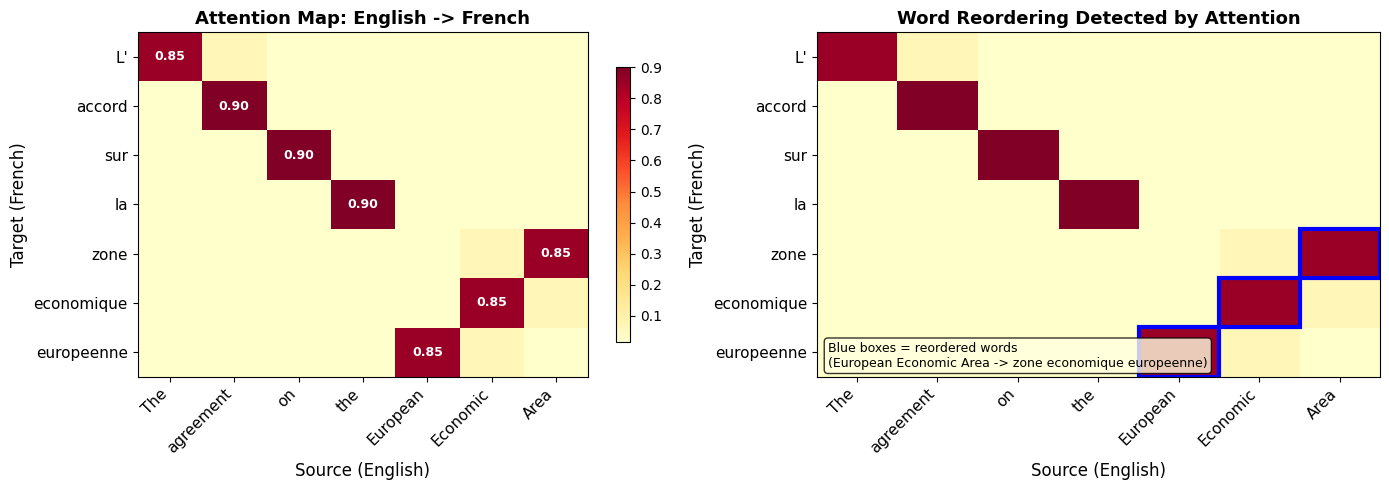

KEY OBSERVATIONS:
  1. The first 4 words align roughly diagonally (monotonic order)
  2. The last 3 words show REORDERING:
     English: "European Economic Area"
     French:  "zone economique europeenne"
     The attention correctly captures that 'Area' maps to 'zone' etc.

  This is the power of attention — it can handle word reordering!


In [12]:
# ============================================================
# B.6b  Heatmap visualization of the attention map
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Main attention map ---
ax = axes[0]
im = ax.imshow(attention_matrix, cmap="YlOrRd", aspect="auto")
ax.set_xticks(range(n_en))
ax.set_xticklabels(english_words, rotation=45, ha="right", fontsize=11)
ax.set_yticks(range(n_fr))
ax.set_yticklabels(french_words, fontsize=11)
ax.set_xlabel("Source (English)", fontsize=12)
ax.set_ylabel("Target (French)", fontsize=12)
ax.set_title("Attention Map: English -> French", fontsize=13, fontweight="bold")
plt.colorbar(im, ax=ax, shrink=0.8)

# Add value annotations
for i in range(n_fr):
    for j in range(n_en):
        val = attention_matrix[i][j]
        if val > 0.3:
            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    fontsize=9, color="white", fontweight="bold")

# --- Right: Highlight word reordering ---
ax = axes[1]
im = ax.imshow(attention_matrix, cmap="YlOrRd", aspect="auto")
ax.set_xticks(range(n_en))
ax.set_xticklabels(english_words, rotation=45, ha="right", fontsize=11)
ax.set_yticks(range(n_fr))
ax.set_yticklabels(french_words, fontsize=11)
ax.set_xlabel("Source (English)", fontsize=12)
ax.set_ylabel("Target (French)", fontsize=12)
ax.set_title("Word Reordering Detected by Attention", fontsize=13, fontweight="bold")

# Draw circles around reordered words
for (fr_idx, en_idx) in [(4, 6), (5, 5), (6, 4)]:
    rect = patches.Rectangle((en_idx - 0.5, fr_idx - 0.5), 1, 1,
                               linewidth=3, edgecolor="blue", facecolor="none")
    ax.add_patch(rect)

ax.text(0.02, 0.02, "Blue boxes = reordered words\n(European Economic Area -> zone economique europeenne)",
        transform=ax.transAxes, fontsize=9, verticalalignment="bottom",
        bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8))

plt.tight_layout()
plt.show()

print("KEY OBSERVATIONS:")
print("  1. The first 4 words align roughly diagonally (monotonic order)")
print("  2. The last 3 words show REORDERING:")
print('     English: "European Economic Area"')
print('     French:  "zone economique europeenne"')
print("     The attention correctly captures that 'Area' maps to 'zone' etc.")
print()
print("  This is the power of attention — it can handle word reordering!")

---
# Part C — CNN Architecture (Slides 14-58)

## C.1  Why CNNs? Fully Connected vs. Convolutional

### A Brief History

CNNs are inspired by the **visual cortex** of the brain:

| Discovery | Year | Key Idea |
|-----------|------|----------|
| Hubel & Wiesel | 1960s | Neurons in the visual cortex respond to specific orientations and positions — **topographical mapping** |
| Neocognitron (Fukushima) | 1980 | Hierarchical model: simple cells -> complex cells -> hypercomplex cells |
| LeNet-5 (LeCun et al.) | 1998 | First practical CNN for digit recognition |
| AlexNet (Krizhevsky et al.) | 2012 | Deep CNN that won ImageNet — started the deep learning revolution |

### The Problem with Fully Connected Layers

Consider classifying a 32x32 colour image (like CIFAR-10):

```
Input image: 32 x 32 x 3 (height x width x RGB channels)
           = 3,072 pixel values

Fully Connected approach:
  Flatten: [pixel_1, pixel_2, ..., pixel_3072]   (1D vector)
     |
     v
  Weight matrix W: (3072 x 10)   <- 30,720 parameters!
     |
     v
  Output: 10 class scores
```

**Problems with Fully Connected:**
1. **Destroys spatial structure** — adjacent pixels are no longer "adjacent"
2. **Too many parameters** — for a 224x224x3 image: 150,528 inputs!
3. **No translation invariance** — a cat in the corner looks completely different
   from a cat in the center

### The Convolutional Approach

CNNs **preserve spatial structure** by using small **filters** (also called
**kernels**) that slide across the image:

```
Fully Connected:                    Convolutional:
  32x32x3 image                       32x32x3 image
       |                                   |
       v                                   v
  FLATTEN to 3072                    KEEP as 32x32x3
       |                                   |
       v                                   v
  W * x (30,720 params)             Slide 5x5 filter (75 params!)
       |                                   |
       v                                   v
  10 activations                     28x28 activation map
```

## C.2  Convolution Operation — From Scratch

A **convolution** is the core operation in CNNs. Here is how it works:

1. Take a small **filter** (e.g., 3x3 or 5x5 grid of numbers)
2. Place it on the top-left corner of the image
3. Multiply each filter value by the corresponding pixel value
4. Sum all the products — this gives you **one number**
5. Slide the filter one position to the right and repeat
6. When you reach the right edge, move down one row and start from the left
7. The result is an **activation map** (or feature map)

```
Image (5x5):                  Filter (3x3):         Activation Map (3x3):
┌───┬───┬───┬───┬───┐        ┌───┬───┬───┐         ┌───┬───┬───┐
│ 1 │ 0 │ 1 │ 0 │ 1 │        │ 1 │ 0 │-1 │         │ ? │ ? │ ? │
├───┼───┼───┼───┼───┤        ├───┼───┼───┤         ├───┼───┼───┤
│ 0 │ 1 │ 0 │ 1 │ 0 │        │ 0 │ 1 │ 0 │         │ ? │ ? │ ? │
├───┼───┼───┼───┼───┤        ├───┼───┼───┤         ├───┼───┼───┤
│ 1 │ 0 │ 1 │ 0 │ 1 │        │-1 │ 0 │ 1 │         │ ? │ ? │ ? │
├───┼───┼───┼───┼───┤        └───┴───┴───┘         └───┴───┴───┘
│ 0 │ 1 │ 0 │ 1 │ 0 │
├───┼───┼───┼───┼───┤
│ 1 │ 0 │ 1 │ 0 │ 1 │
└───┴───┴───┴───┴───┘
```

In [13]:
# ============================================================
# C.2  Implement 2D convolution from scratch
# ============================================================

def conv2d(image, kernel, stride=1, padding=0):
    '''
    Perform 2D convolution of a single-channel image with a kernel.

    Args:
        image   : 2D numpy array (height x width)
        kernel  : 2D numpy array (kh x kw) — the filter
        stride  : how many pixels to move the filter each step
        padding : number of zero-padding pixels around the image

    Returns:
        output  : 2D numpy array — the activation/feature map
    '''
    # Add zero-padding if requested
    if padding > 0:
        image = np.pad(image, padding, mode='constant', constant_values=0)

    img_h, img_w = image.shape
    ker_h, ker_w = kernel.shape

    # Compute output dimensions
    out_h = (img_h - ker_h) // stride + 1
    out_w = (img_w - ker_w) // stride + 1

    # Allocate output
    output = np.zeros((out_h, out_w))

    # Slide the kernel across the image
    for i in range(out_h):
        for j in range(out_w):
            # Extract the patch under the kernel
            row_start = i * stride
            col_start = j * stride
            patch = image[row_start:row_start+ker_h, col_start:col_start+ker_w]

            # Element-wise multiply and sum (dot product)
            output[i, j] = np.sum(patch * kernel)

    return output


# ----- Demo: Convolve a 5x5 image with a 3x3 filter -----
image = np.array([
    [1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0],
    [1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0],
    [1, 0, 1, 0, 1]
], dtype=float)

kernel = np.array([
    [ 1,  0, -1],
    [ 0,  1,  0],
    [-1,  0,  1]
], dtype=float)

result = conv2d(image, kernel)

print("2D CONVOLUTION FROM SCRATCH")
print("=" * 60)
print()
print("Input Image (5x5):")
print(image)
print()
print("Kernel/Filter (3x3):")
print(kernel)
print()
print("Output Activation Map (3x3):")
print(result)
print()
print("Detailed computation for position (0,0):")
patch = image[0:3, 0:3]
print(f"  Patch at (0,0):")
print(f"    {patch[0]}")
print(f"    {patch[1]}")
print(f"    {patch[2]}")
products = patch * kernel
print(f"  Element-wise multiply with kernel:")
print(f"    {products[0]}")
print(f"    {products[1]}")
print(f"    {products[2]}")
print(f"  Sum = {products.sum():.0f}")

2D CONVOLUTION FROM SCRATCH

Input Image (5x5):
[[1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1.]]

Kernel/Filter (3x3):
[[ 1.  0. -1.]
 [ 0.  1.  0.]
 [-1.  0.  1.]]

Output Activation Map (3x3):
[[1. 0. 1.]
 [0. 1. 0.]
 [1. 0. 1.]]

Detailed computation for position (0,0):
  Patch at (0,0):
    [1. 0. 1.]
    [0. 1. 0.]
    [1. 0. 1.]
  Element-wise multiply with kernel:
    [ 1.  0. -1.]
    [0. 1. 0.]
    [-1.  0.  1.]
  Sum = 1


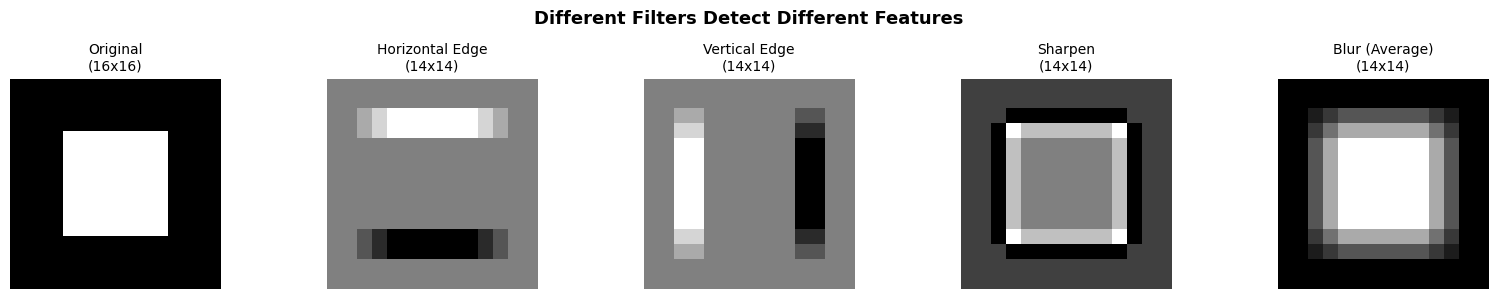

FILTERS IN CNNs:
  - Horizontal Edge filter detects horizontal boundaries
  - Vertical Edge filter detects vertical boundaries
  - Sharpen filter enhances edges and details
  - Blur (Average) filter smooths the image

In a CNN, the network LEARNS what filters to use!
Early layers learn edge detectors; deeper layers learn complex patterns.


In [14]:
# ============================================================
# C.2b  Real-world filters: Edge detection and Blur
# ============================================================

# Create a simple test image (a white square on black background)
test_image = np.zeros((16, 16))
test_image[4:12, 4:12] = 1.0  # White square in the center

# Common filters used in image processing and CNNs:
filters = {
    "Horizontal Edge": np.array([[-1, -1, -1],
                                  [ 0,  0,  0],
                                  [ 1,  1,  1]], dtype=float),

    "Vertical Edge":   np.array([[-1, 0, 1],
                                  [-1, 0, 1],
                                  [-1, 0, 1]], dtype=float),

    "Sharpen":         np.array([[ 0, -1,  0],
                                  [-1,  5, -1],
                                  [ 0, -1,  0]], dtype=float),

    "Blur (Average)":  np.ones((3, 3)) / 9.0,
}

fig, axes = plt.subplots(1, 5, figsize=(16, 3))

# Original image
axes[0].imshow(test_image, cmap="gray", vmin=0, vmax=1)
axes[0].set_title("Original\n(16x16)", fontsize=10)
axes[0].axis("off")

# Apply each filter
for idx, (name, kernel) in enumerate(filters.items()):
    result = conv2d(test_image, kernel)
    axes[idx+1].imshow(result, cmap="gray")
    axes[idx+1].set_title(f"{name}\n({result.shape[0]}x{result.shape[1]})", fontsize=10)
    axes[idx+1].axis("off")

plt.suptitle("Different Filters Detect Different Features", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("FILTERS IN CNNs:")
print("  - Horizontal Edge filter detects horizontal boundaries")
print("  - Vertical Edge filter detects vertical boundaries")
print("  - Sharpen filter enhances edges and details")
print("  - Blur (Average) filter smooths the image")
print()
print("In a CNN, the network LEARNS what filters to use!")
print("Early layers learn edge detectors; deeper layers learn complex patterns.")

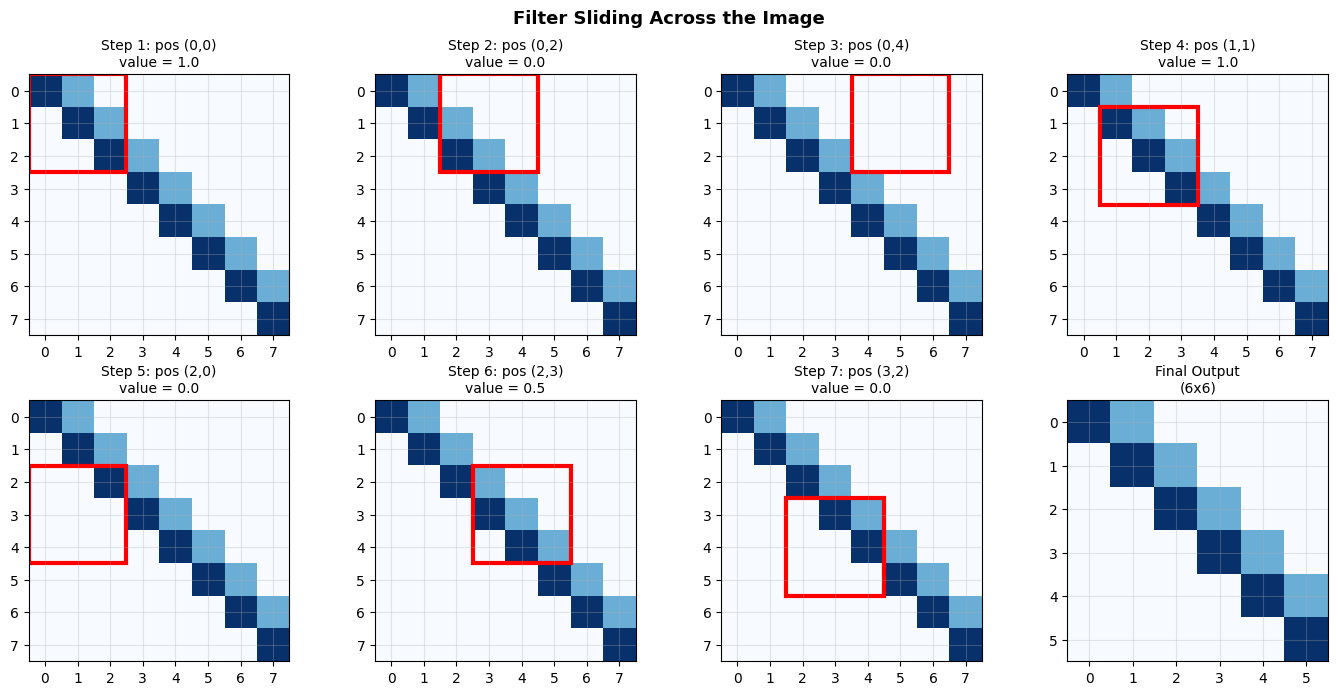

The red box shows the 3x3 filter at each position.
At each position, we compute: sum(patch * kernel).
The filter slides left-to-right, top-to-bottom.


In [15]:
# ============================================================
# C.2c  Visualize filter sliding over an image
# ============================================================

# Create a more interesting image: a diagonal line
img_size = 8
slide_image = np.zeros((img_size, img_size))
for i in range(img_size):
    slide_image[i, i] = 1.0
    if i + 1 < img_size:
        slide_image[i, i+1] = 0.5

# Use a simple 3x3 identity-like filter
slide_kernel = np.array([[0, 0, 0],
                          [0, 1, 0],
                          [0, 0, 0]], dtype=float)

result = conv2d(slide_image, slide_kernel)

# Show a few steps of the convolution
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

steps = [(0,0), (0,2), (0,4), (1,1), (2,0), (2,3), (3,2), (4,4)]

for idx, (r, c) in enumerate(steps[:4]):
    ax = axes[0, idx]
    ax.imshow(slide_image, cmap="Blues", vmin=0, vmax=1)
    # Highlight the patch being convolved
    rect = patches.Rectangle((c-0.5, r-0.5), 3, 3,
                               linewidth=3, edgecolor="red", facecolor="none")
    ax.add_patch(rect)
    # Show the computed value
    patch = slide_image[r:r+3, c:c+3]
    val = np.sum(patch * slide_kernel)
    ax.set_title(f"Step {idx+1}: pos ({r},{c})\nvalue = {val:.1f}", fontsize=10)
    ax.set_xticks(range(img_size))
    ax.set_yticks(range(img_size))
    ax.grid(True, alpha=0.3)

# Show the result
for idx, (r, c) in enumerate(steps[4:8]):
    ax = axes[1, idx]
    if idx < 3:
        ax.imshow(slide_image, cmap="Blues", vmin=0, vmax=1)
        rect = patches.Rectangle((c-0.5, r-0.5), 3, 3,
                                   linewidth=3, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        patch = slide_image[r:r+3, c:c+3]
        val = np.sum(patch * slide_kernel)
        ax.set_title(f"Step {idx+5}: pos ({r},{c})\nvalue = {val:.1f}", fontsize=10)
        ax.set_xticks(range(img_size))
        ax.set_yticks(range(img_size))
        ax.grid(True, alpha=0.3)
    else:
        ax.imshow(result, cmap="Blues")
        ax.set_title(f"Final Output\n({result.shape[0]}x{result.shape[1]})", fontsize=10)
        ax.set_xticks(range(result.shape[1]))
        ax.set_yticks(range(result.shape[0]))
        ax.grid(True, alpha=0.3)

plt.suptitle("Filter Sliding Across the Image", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("The red box shows the 3x3 filter at each position.")
print("At each position, we compute: sum(patch * kernel).")
print("The filter slides left-to-right, top-to-bottom.")

## C.3  Multiple Filters = Multiple Activation Maps

A single filter detects ONE type of feature (e.g., horizontal edges).
To detect many different features, we use **multiple filters**.

Each filter produces its own activation map. If we have 6 filters applied
to a 32x32 image with 3x3 kernels, we get:

```
Input: 32 x 32 x 3               6 Filters (each 3x3x3)
                                        |
                                        v
                                  6 Activation Maps
                                  each 30 x 30

                          ┌──────────────────────┐
                          │  Map 1 (edges?)      │
                          │  Map 2 (corners?)    │
                          │  Map 3 (textures?)   │
                          │  Map 4 (gradients?)  │
                          │  Map 5 (blobs?)      │
                          │  Map 6 (colors?)     │
                          └──────────────────────┘
                          Output: 30 x 30 x 6
```

The **depth** of the output equals the **number of filters**.

> **Important:** Each filter extends through the full depth of the input.
> A 3x3 filter on a 3-channel (RGB) image is actually 3x3x3 = 27 values.

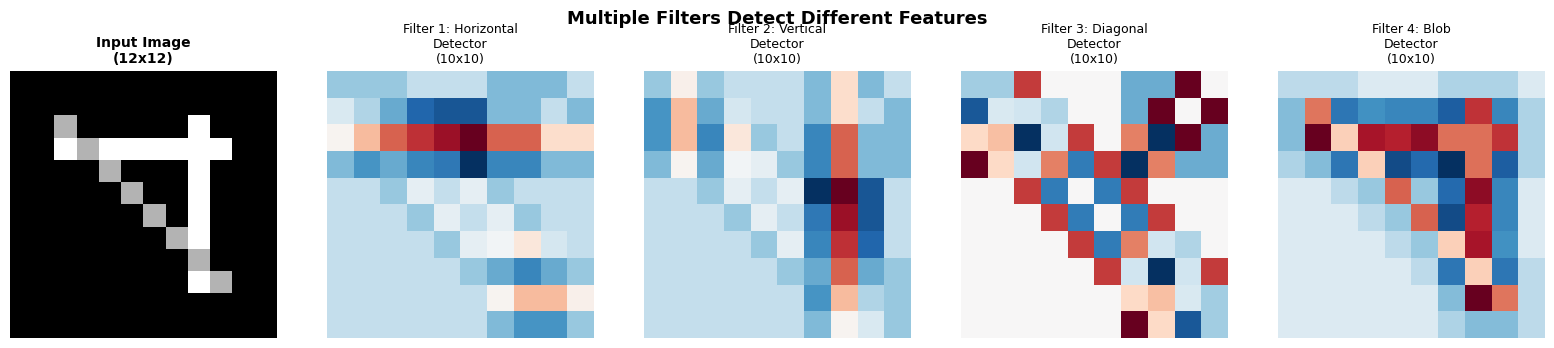

Each filter detects a DIFFERENT type of feature:
  Filter 1: Responds to horizontal edges
  Filter 2: Responds to vertical edges
  Filter 3: Responds to diagonal edges
  Filter 4: Responds to isolated bright spots (blobs)

Input shape:  (12, 12)
Output shape: (10, 10, 4)  — stack of 4 activation maps

In a CNN, these filters are LEARNED during training.
The network discovers which features are useful for the task!


In [16]:
# ============================================================
# C.3  Multiple filters producing multiple activation maps
# ============================================================

# Create a 12x12 test image with interesting features
np.random.seed(42)
test_img = np.zeros((12, 12))
# Horizontal line
test_img[3, 2:10] = 1.0
# Vertical line
test_img[2:10, 8] = 1.0
# Diagonal
for i in range(8):
    test_img[2+i, 2+i] = 0.7

# Define multiple 3x3 filters
multi_filters = {
    "Horizontal\nDetector": np.array([[-1, -1, -1],
                                       [ 2,  2,  2],
                                       [-1, -1, -1]], dtype=float),
    "Vertical\nDetector":   np.array([[-1, 2, -1],
                                       [-1, 2, -1],
                                       [-1, 2, -1]], dtype=float),
    "Diagonal\nDetector":   np.array([[-1, -1, 2],
                                       [-1, 2, -1],
                                       [ 2, -1, -1]], dtype=float),
    "Blob\nDetector":       np.array([[-1, -1, -1],
                                       [-1,  8, -1],
                                       [-1, -1, -1]], dtype=float),
}

fig, axes = plt.subplots(1, 5, figsize=(16, 3.5))

# Show original
axes[0].imshow(test_img, cmap="gray")
axes[0].set_title("Input Image\n(12x12)", fontsize=10, fontweight="bold")
axes[0].axis("off")

# Apply each filter
for idx, (name, kernel) in enumerate(multi_filters.items()):
    result = conv2d(test_img, kernel)
    axes[idx+1].imshow(result, cmap="RdBu_r")
    axes[idx+1].set_title(f"Filter {idx+1}: {name}\n({result.shape[0]}x{result.shape[1]})", fontsize=9)
    axes[idx+1].axis("off")

plt.suptitle("Multiple Filters Detect Different Features", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("Each filter detects a DIFFERENT type of feature:")
print("  Filter 1: Responds to horizontal edges")
print("  Filter 2: Responds to vertical edges")
print("  Filter 3: Responds to diagonal edges")
print("  Filter 4: Responds to isolated bright spots (blobs)")
print()
print(f"Input shape:  (12, 12)")
print(f"Output shape: (10, 10, 4)  — stack of 4 activation maps")
print()
print("In a CNN, these filters are LEARNED during training.")
print("The network discovers which features are useful for the task!")

## C.4  Stride and Padding

### Stride

The **stride** controls how many pixels the filter moves at each step.

```
Stride 1 (default):            Stride 2:
┌─┬─┬─┬─┬─┐  ┌─┬─┬─┬─┬─┐    ┌─┬─┬─┬─┬─┐  ┌─┬─┬─┬─┬─┐
│X│X│X│ │ │  │ │X│X│X│ │    │X│X│X│ │ │  │ │ │X│X│X│
│X│X│X│ │ │  │ │X│X│X│ │    │X│X│X│ │ │  │ │ │X│X│X│
│X│X│X│ │ │  │ │X│X│X│ │    │X│X│X│ │ │  │ │ │X│X│X│
│ │ │ │ │ │  │ │ │ │ │ │    │ │ │ │ │ │  │ │ │ │ │ │
│ │ │ │ │ │  │ │ │ │ │ │    │ │ │ │ │ │  │ │ │ │ │ │
└─┴─┴─┴─┴─┘  └─┴─┴─┴─┴─┘    └─┴─┴─┴─┴─┘  └─┴─┴─┴─┴─┘
 Position 1    Position 2      Position 1    Position 2
 (moves 1)     (moves 1)      (moves 2)     (skips one)
```

Stride 1 = fine-grained, larger output. Stride 2 = coarser, smaller output.

### Padding

**Padding** adds zeros around the border of the image. This controls the
output size and prevents the image from shrinking too fast.

```
No padding (valid):           Padding = 1 (same):
Input: 5x5                   Input: 5x5 + border of zeros
                              ┌─┬─┬─┬─┬─┬─┬─┐
┌─┬─┬─┬─┬─┐                  │0│0│0│0│0│0│0│
│ │ │ │ │ │                  ├─┼─┼─┼─┼─┼─┼─┤
│ │ │ │ │ │  3x3 filter ->   │0│ │ │ │ │ │0│
│ │ │ │ │ │  Output: 3x3     │0│ │ │ │ │ │0│  3x3 filter ->
│ │ │ │ │ │                  │0│ │ │ │ │ │0│  Output: 5x5
│ │ │ │ │ │                  │0│ │ │ │ │ │0│  (same as input!)
└─┴─┴─┴─┴─┘                  │0│ │ │ │ │ │0│
                              │0│0│0│0│0│0│0│
                              └─┴─┴─┴─┴─┴─┴─┘
```

### Output Size Formula

$$w_{out} = \left\lfloor \frac{w_{in} + 2p - k}{s} \right\rfloor + 1$$

Where:
- $w_{in}$ = input width (or height)
- $p$ = padding
- $k$ = kernel (filter) size
- $s$ = stride
- $\lfloor \cdot \rfloor$ = floor (round down)

OUTPUT SIZE FORMULA: w_out = floor((w_in + 2p - k) / s) + 1

Input image size: 8 x 8
Kernel size:      3 x 3

Configuration                  Calculation                          Output Size
--------------------------------------------------------------------------------
  Stride 1, No Padding         (8 + 2*0 - 3) / 1 + 1 = 6             6 x 6
  Stride 1, Padding 1          (8 + 2*1 - 3) / 1 + 1 = 8             8 x 8
  Stride 2, No Padding         (8 + 2*0 - 3) / 2 + 1 = 3             3 x 3
  Stride 2, Padding 1          (8 + 2*1 - 3) / 2 + 1 = 4             4 x 4
  Stride 1, Padding 2          (8 + 2*2 - 3) / 1 + 1 = 10           10 x 10
  Stride 3, No Padding         (8 + 2*0 - 3) / 3 + 1 = 2             2 x 2



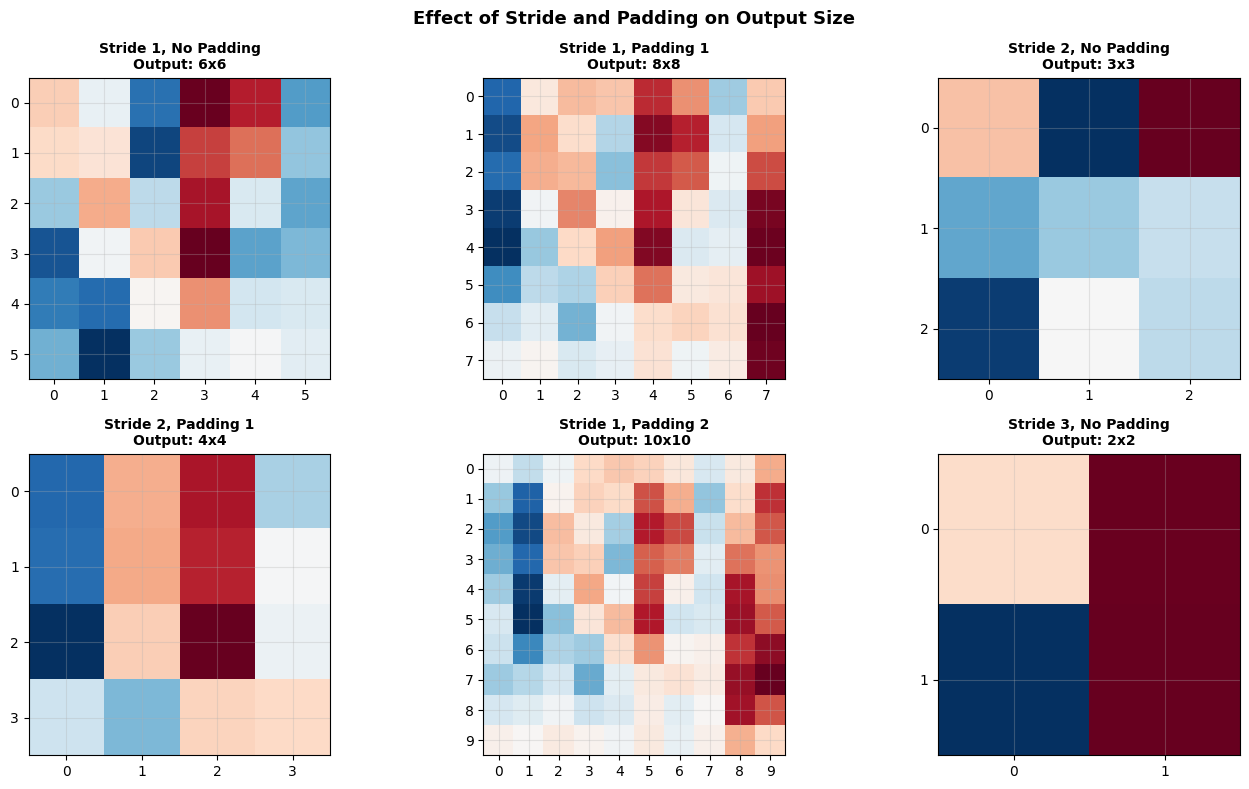

KEY TAKEAWAYS:
  - Larger stride  -> smaller output (downsamples)
  - More padding   -> larger output (preserves spatial size)
  - Padding=1 with stride=1 and 3x3 kernel -> output = input size ('same' convolution)


In [17]:
# ============================================================
# C.4  Demonstrate stride and padding
# ============================================================

def output_size(w_in, kernel_size, stride, padding):
    '''Compute the output size of a convolution.'''
    return (w_in + 2 * padding - kernel_size) // stride + 1


# Create a test image
np.random.seed(42)
img = np.random.rand(8, 8)
kernel_3x3 = np.array([[1, 0, -1],
                         [2, 0, -2],
                         [1, 0, -1]], dtype=float) / 4  # Sobel-X

print("OUTPUT SIZE FORMULA: w_out = floor((w_in + 2p - k) / s) + 1")
print("=" * 65)
print()
print(f"Input image size: 8 x 8")
print(f"Kernel size:      3 x 3")
print()

configs = [
    (1, 0, "Stride 1, No Padding"),
    (1, 1, "Stride 1, Padding 1"),
    (2, 0, "Stride 2, No Padding"),
    (2, 1, "Stride 2, Padding 1"),
    (1, 2, "Stride 1, Padding 2"),
    (3, 0, "Stride 3, No Padding"),
]

print(f"{'Configuration':<30s} {'Calculation':<35s} {'Output Size':>12s}")
print("-" * 80)
for stride, padding, name in configs:
    out = output_size(8, 3, stride, padding)
    calc = f"({8} + 2*{padding} - 3) / {stride} + 1 = {out}"
    print(f"  {name:<28s} {calc:<35s} {out:>3d} x {out}")

print()

# Apply convolution with different strides and padding
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for idx, (stride, padding, name) in enumerate(configs):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]

    result = conv2d(img, kernel_3x3, stride=stride, padding=padding)
    ax.imshow(result, cmap="RdBu_r")
    out_h, out_w = result.shape
    ax.set_title(f"{name}\nOutput: {out_h}x{out_w}", fontsize=10, fontweight="bold")
    ax.set_xticks(range(out_w))
    ax.set_yticks(range(out_h))
    ax.grid(True, alpha=0.3)

plt.suptitle("Effect of Stride and Padding on Output Size", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("KEY TAKEAWAYS:")
print("  - Larger stride  -> smaller output (downsamples)")
print("  - More padding   -> larger output (preserves spatial size)")
print("  - Padding=1 with stride=1 and 3x3 kernel -> output = input size ('same' convolution)")

In [18]:
# ============================================================
# C.4b  Interactive output size examples
# ============================================================

print("OUTPUT SIZE CALCULATOR")
print("=" * 65)
print()
print("Common configurations used in practice:")
print()
print(f"{'Input':>7s}  {'Kernel':>7s}  {'Stride':>7s}  {'Pad':>5s}  {'Output':>7s}  {'Network'}")
print("-" * 65)

examples = [
    (32,  5, 1, 0, "LeNet-5 (conv1)"),
    (28,  5, 1, 0, "LeNet-5 (conv2)"),
    (224, 11, 4, 2, "AlexNet (conv1)"),
    (224, 7, 2, 3, "ResNet (conv1)"),
    (224, 3, 1, 1, "VGG (all convs)"),
    (56,  3, 1, 1, "VGG (mid layers)"),
    (7,   3, 1, 1, "VGG (late layers)"),
]

for w_in, k, s, p, net_name in examples:
    out = output_size(w_in, k, s, p)
    print(f"  {w_in:>5d}  {k:>5d}x{k}  {s:>5d}    {p:>3d}  {out:>5d}    {net_name}")

print()
print("Notice:")
print("  - LeNet-5: No padding -> output shrinks each layer")
print("  - AlexNet: Large 11x11 kernel with stride 4 -> aggressive downsampling")
print("  - VGG: Always 3x3 kernel, stride 1, padding 1 -> output = input size")
print("  - This 'same' convolution (3x3, stride 1, pad 1) is the most popular choice!")

OUTPUT SIZE CALCULATOR

Common configurations used in practice:

  Input   Kernel   Stride    Pad   Output  Network
-----------------------------------------------------------------
     32      5x5      1      0     28    LeNet-5 (conv1)
     28      5x5      1      0     24    LeNet-5 (conv2)
    224     11x11      4      2     55    AlexNet (conv1)
    224      7x7      2      3    112    ResNet (conv1)
    224      3x3      1      1    224    VGG (all convs)
     56      3x3      1      1     56    VGG (mid layers)
      7      3x3      1      1      7    VGG (late layers)

Notice:
  - LeNet-5: No padding -> output shrinks each layer
  - AlexNet: Large 11x11 kernel with stride 4 -> aggressive downsampling
  - VGG: Always 3x3 kernel, stride 1, padding 1 -> output = input size
  - This 'same' convolution (3x3, stride 1, pad 1) is the most popular choice!


## C.5  Pooling — Downsampling Feature Maps

After convolution, we often want to **reduce the spatial size** of the feature
map. This is done with **pooling** (also called subsampling or downsampling).

### Max Pooling

The most common type is **Max Pooling**:
- Take a small window (e.g., 2x2)
- Keep only the **maximum** value in each window
- Move the window with a stride (usually equal to the window size)

```
Input (4x4):              Max Pool (2x2, stride 2):    Output (2x2):

┌───┬───┬───┬───┐         ┌───┬───┐───┬───┐           ┌───┬───┐
│ 1 │ 3 │ 2 │ 1 │         │ 1 │ 3 │ 2 │ 1 │           │ 4 │ 6 │
├───┼───┤───┼───┤   -->   │   max  │  max  │   ==>    ├───┼───┤
│ 4 │ 2 │ 6 │ 4 │         │ 4 │ 2 │ 6 │ 4 │           │ 8 │ 7 │
├───┼───┼───┼───┤         ├───┼───┼───┼───┤           └───┴───┘
│ 7 │ 8 │ 3 │ 2 │         │ 7 │ 8 │ 3 │ 2 │
├───┼───┤───┼───┤         │   max  │  max  │
│ 1 │ 0 │ 5 │ 7 │         │ 1 │ 0 │ 5 │ 7 │
└───┴───┴───┴───┘         └───┴───┴───┴───┘
```

### Why Pool?

1. **Reduces computation** — fewer values to process in the next layer
2. **Reduces overfitting** — fewer parameters
3. **Translation invariance** — small shifts in the input do not change the output much

In [19]:
# ============================================================
# C.5  Max Pooling from scratch
# ============================================================

def max_pool2d(feature_map, pool_size=2, stride=2):
    '''
    Apply max pooling to a 2D feature map.

    Args:
        feature_map : 2D numpy array
        pool_size   : size of the pooling window (default 2x2)
        stride      : stride of the pooling window (default 2)

    Returns:
        pooled : 2D numpy array (downsampled)
    '''
    h, w = feature_map.shape
    out_h = (h - pool_size) // stride + 1
    out_w = (w - pool_size) // stride + 1

    pooled = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            row_start = i * stride
            col_start = j * stride
            window = feature_map[row_start:row_start+pool_size,
                                 col_start:col_start+pool_size]
            pooled[i, j] = np.max(window)

    return pooled


# ----- Demo -----
input_map = np.array([
    [1, 3, 2, 1],
    [4, 2, 6, 4],
    [7, 8, 3, 2],
    [1, 0, 5, 7]
], dtype=float)

pooled = max_pool2d(input_map, pool_size=2, stride=2)

print("MAX POOLING — From Scratch")
print("=" * 50)
print()
print("Input (4x4):")
print(input_map.astype(int))
print()
print("Max Pool with 2x2 window, stride 2:")
print()

# Show step-by-step
for i in range(2):
    for j in range(2):
        window = input_map[i*2:i*2+2, j*2:j*2+2]
        print(f"  Window at ({i},{j}): {window.flatten().astype(int)} -> max = {int(pooled[i,j])}")

print()
print("Output (2x2):")
print(pooled.astype(int))
print()
print(f"Size reduced from {input_map.shape} to {pooled.shape}")
print(f"That is a 75% reduction in values! (16 -> 4)")

MAX POOLING — From Scratch

Input (4x4):
[[1 3 2 1]
 [4 2 6 4]
 [7 8 3 2]
 [1 0 5 7]]

Max Pool with 2x2 window, stride 2:

  Window at (0,0): [1 3 4 2] -> max = 4
  Window at (0,1): [2 1 6 4] -> max = 6
  Window at (1,0): [7 8 1 0] -> max = 8
  Window at (1,1): [3 2 5 7] -> max = 7

Output (2x2):
[[4 6]
 [8 7]]

Size reduced from (4, 4) to (2, 2)
That is a 75% reduction in values! (16 -> 4)


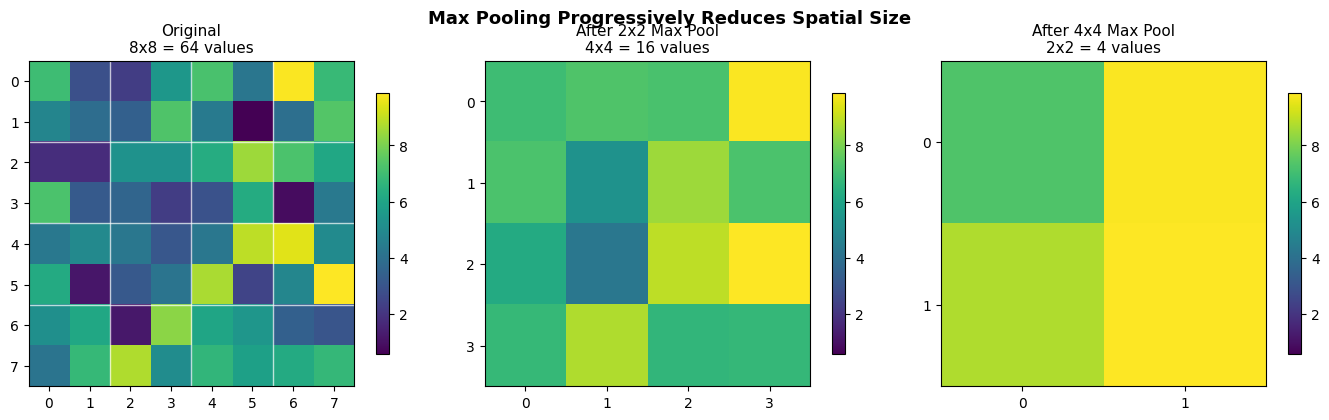

Original:      (8, 8)  (64 values)
After 2x2 pool: (4, 4)  (16 values) — 75% reduction
After 4x4 pool: (2, 2)  (4 values) — 96.9% reduction

Pooling keeps the STRONGEST activations (max values) while
dramatically reducing the amount of data to process.


In [20]:
# ============================================================
# C.5b  Visualize max pooling on a larger feature map
# ============================================================

# Create a more interesting feature map
np.random.seed(123)
large_map = np.random.rand(8, 8) * 10

pooled_2x2 = max_pool2d(large_map, pool_size=2, stride=2)
pooled_4x4 = max_pool2d(large_map, pool_size=4, stride=4)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Original
ax = axes[0]
im = ax.imshow(large_map, cmap="viridis")
ax.set_title(f"Original\n{large_map.shape[0]}x{large_map.shape[1]} = {large_map.size} values", fontsize=11)
# Draw 2x2 grid
for i in range(1, 4):
    ax.axhline(y=i*2-0.5, color="white", linewidth=1, alpha=0.7)
    ax.axvline(x=i*2-0.5, color="white", linewidth=1, alpha=0.7)
ax.set_xticks(range(8))
ax.set_yticks(range(8))
plt.colorbar(im, ax=ax, shrink=0.8)

# 2x2 pool
ax = axes[1]
im = ax.imshow(pooled_2x2, cmap="viridis",
               vmin=large_map.min(), vmax=large_map.max())
ax.set_title(f"After 2x2 Max Pool\n{pooled_2x2.shape[0]}x{pooled_2x2.shape[1]} = {pooled_2x2.size} values", fontsize=11)
ax.set_xticks(range(pooled_2x2.shape[1]))
ax.set_yticks(range(pooled_2x2.shape[0]))
plt.colorbar(im, ax=ax, shrink=0.8)

# 4x4 pool
ax = axes[2]
im = ax.imshow(pooled_4x4, cmap="viridis",
               vmin=large_map.min(), vmax=large_map.max())
ax.set_title(f"After 4x4 Max Pool\n{pooled_4x4.shape[0]}x{pooled_4x4.shape[1]} = {pooled_4x4.size} values", fontsize=11)
ax.set_xticks(range(pooled_4x4.shape[1]))
ax.set_yticks(range(pooled_4x4.shape[0]))
plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle("Max Pooling Progressively Reduces Spatial Size", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"Original:      {large_map.shape}  ({large_map.size} values)")
print(f"After 2x2 pool: {pooled_2x2.shape}  ({pooled_2x2.size} values) — 75% reduction")
print(f"After 4x4 pool: {pooled_4x4.shape}  ({pooled_4x4.size} values) — 96.9% reduction")
print()
print("Pooling keeps the STRONGEST activations (max values) while")
print("dramatically reducing the amount of data to process.")

## C.6  Full ConvNet Pipeline — Putting It All Together

A typical CNN stacks convolution, activation (ReLU), and pooling layers:

```
Input Image
     │
     ▼
┌──────────┐
│  CONV    │  ← Learn filters (e.g., 3x3)
│  (3x3)   │
└────┬─────┘
     │
     ▼
┌──────────┐
│  ReLU    │  ← Activation: max(0, x) — removes negative values
└────┬─────┘
     │
     ▼
┌──────────┐
│  CONV    │  ← More filters
│  (3x3)   │
└────┬─────┘
     │
     ▼
┌──────────┐
│  ReLU    │
└────┬─────┘
     │
     ▼
┌──────────┐
│  POOL    │  ← Max pooling: reduce spatial size
│  (2x2)   │
└────┬─────┘
     │
     ▼
  ... repeat ...
     │
     ▼
┌──────────┐
│  FLATTEN │  ← Convert 2D maps to 1D vector
└────┬─────┘
     │
     ▼
┌──────────┐
│  FC      │  ← Fully connected layer for classification
│  (Dense) │
└────┬─────┘
     │
     ▼
  Class scores
```

### ReLU Activation

**ReLU** (Rectified Linear Unit) is the most popular activation function:

$$\text{ReLU}(x) = \max(0, x)$$

It simply replaces all negative values with zero. This introduces
**non-linearity** — without it, stacking multiple convolution layers
would be equivalent to a single linear operation.

### Hierarchical Features

As we go deeper in a CNN, the features become more complex:

```
Layer 1 (early):    Edges, corners, simple textures
Layer 2-3 (mid):    Patterns, parts (eyes, wheels, petals)
Layer 4-5 (deep):   Objects, faces, scenes
Final layer:        Category (dog, cat, car, airplane)
```

This progression from simple to complex is similar to how the visual
cortex processes information: simple cells -> complex cells -> hypercomplex cells.

In [21]:
# ============================================================
# C.6  Full ConvNet pipeline on a sample image
# ============================================================

def relu(x):
    '''ReLU activation: max(0, x)'''
    return np.maximum(0, x)

# Create a synthetic 16x16 image with a recognisable pattern
# (checkerboard with some noise)
np.random.seed(42)
sample_image = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        if (i // 4 + j // 4) % 2 == 0:
            sample_image[i, j] = 0.8 + np.random.rand() * 0.2
        else:
            sample_image[i, j] = np.random.rand() * 0.2

# Define filters for the pipeline
edge_filter = np.array([[-1, -1, -1],
                          [ 0,  0,  0],
                          [ 1,  1,  1]], dtype=float) / 3

corner_filter = np.array([[-1,  0,  1],
                            [ 0,  0,  0],
                            [ 1,  0, -1]], dtype=float) / 2

# ===== PIPELINE =====
print("FULL CNN PIPELINE (from scratch!)")
print("=" * 60)
print()

# Stage 1: CONV
print("Stage 1: CONVOLUTION (3x3 edge filter)")
conv1 = conv2d(sample_image, edge_filter)
print(f"  Input:  {sample_image.shape} -> Output: {conv1.shape}")

# Stage 2: ReLU
print("Stage 2: ReLU (remove negatives)")
relu1 = relu(conv1)
neg_count = np.sum(conv1 < 0)
print(f"  Zeroed out {neg_count} negative values out of {conv1.size}")

# Stage 3: CONV
print("Stage 3: CONVOLUTION (3x3 corner filter)")
conv2 = conv2d(relu1, corner_filter)
print(f"  Input:  {relu1.shape} -> Output: {conv2.shape}")

# Stage 4: ReLU
print("Stage 4: ReLU")
relu2 = relu(conv2)
neg_count = np.sum(conv2 < 0)
print(f"  Zeroed out {neg_count} negative values out of {conv2.size}")

# Stage 5: Max Pool
print("Stage 5: MAX POOLING (2x2, stride 2)")
pool1 = max_pool2d(relu2, pool_size=2, stride=2)
print(f"  Input:  {relu2.shape} -> Output: {pool1.shape}")

# Stage 6: Flatten
flat = pool1.flatten()
print(f"Stage 6: FLATTEN")
print(f"  Input:  {pool1.shape} -> Output: ({flat.shape[0]},)")

# Stage 7: Fully connected (simulated)
num_classes = 3
fc_weights = np.random.randn(flat.shape[0], num_classes) * 0.1
fc_bias = np.zeros(num_classes)
class_scores = flat @ fc_weights + fc_bias
print(f"Stage 7: FULLY CONNECTED ({flat.shape[0]} -> {num_classes})")
print(f"  Class scores: {class_scores.round(3)}")

# Apply softmax for probabilities
probs = softmax(class_scores)
classes = ["Cat", "Dog", "Bird"]
print(f"\n  Predictions (after softmax):")
for i, cls in enumerate(classes):
    bar = "#" * int(probs[i] * 30)
    print(f"    {cls:5s}: {probs[i]*100:5.1f}%  {bar}")
print()
print("(Predictions are random because weights are random — not trained!)")

FULL CNN PIPELINE (from scratch!)

Stage 1: CONVOLUTION (3x3 edge filter)
  Input:  (16, 16) -> Output: (14, 14)
Stage 2: ReLU (remove negatives)
  Zeroed out 96 negative values out of 196
Stage 3: CONVOLUTION (3x3 corner filter)
  Input:  (14, 14) -> Output: (12, 12)
Stage 4: ReLU
  Zeroed out 65 negative values out of 144
Stage 5: MAX POOLING (2x2, stride 2)
  Input:  (12, 12) -> Output: (6, 6)
Stage 6: FLATTEN
  Input:  (6, 6) -> Output: (36,)
Stage 7: FULLY CONNECTED (36 -> 3)
  Class scores: [ 0.118  0.013 -0.06 ]

  Predictions (after softmax):
    Cat  :  36.5%  ##########
    Dog  :  32.9%  #########
    Bird :  30.6%  #########

(Predictions are random because weights are random — not trained!)


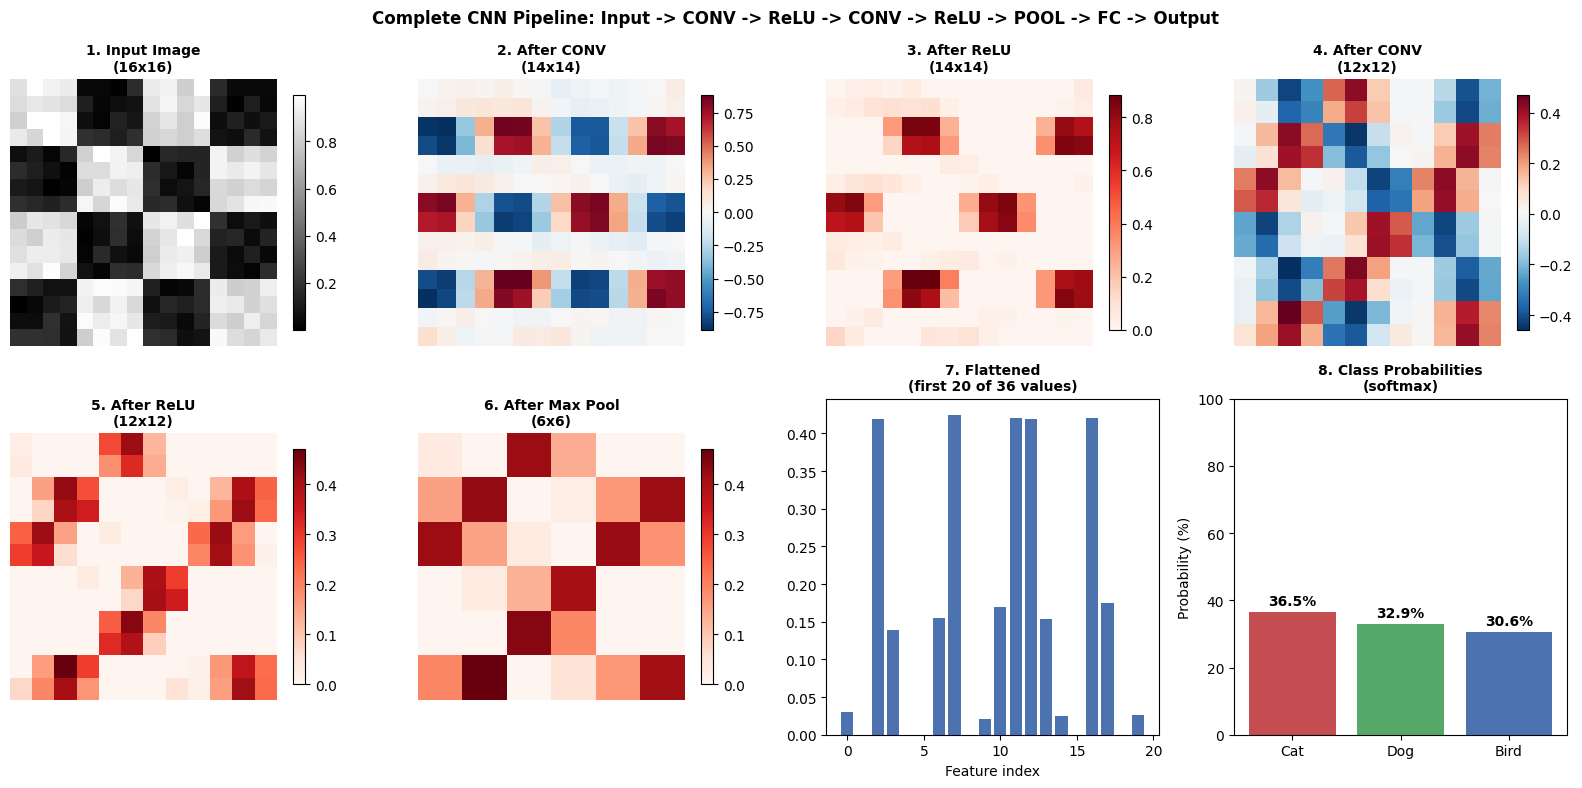

This is the FULL pipeline of a simple CNN!

Summary of spatial dimensions:
  Input:      16 x 16
  After Conv: 14 x 14  (3x3 kernel, no padding)
  After ReLU: 14 x 14  (shape unchanged, just clamps negatives)
  After Conv: 12 x 12  (another 3x3 kernel)
  After ReLU: 12 x 12
  After Pool:  6 x  6  (2x2 max pool, stride 2)
  Flatten:     36      (6*6)
  FC output:    3      (one score per class)


In [22]:
# ============================================================
# C.6b  Visualize each stage of the pipeline
# ============================================================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

stages = [
    (sample_image, "1. Input Image\n(16x16)", "gray"),
    (conv1, "2. After CONV\n(14x14)", "RdBu_r"),
    (relu1, "3. After ReLU\n(14x14)", "Reds"),
    (conv2, "4. After CONV\n(12x12)", "RdBu_r"),
    (relu2, "5. After ReLU\n(12x12)", "Reds"),
    (pool1, "6. After Max Pool\n(6x6)", "Reds"),
]

for idx, (data, title, cmap) in enumerate(stages):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    im = ax.imshow(data, cmap=cmap)
    ax.set_title(title, fontsize=10, fontweight="bold")
    ax.axis("off")
    plt.colorbar(im, ax=ax, shrink=0.7)

# Show flatten + FC in remaining plots
ax = axes[1, 2]
ax.bar(range(len(flat[:20])), flat[:20], color="#4C72B0")
ax.set_title(f"7. Flattened\n(first 20 of {len(flat)} values)", fontsize=10, fontweight="bold")
ax.set_xlabel("Feature index")

ax = axes[1, 3]
bars = ax.bar(classes, probs * 100, color=["#C44E52", "#55A868", "#4C72B0"])
ax.set_title("8. Class Probabilities\n(softmax)", fontsize=10, fontweight="bold")
ax.set_ylabel("Probability (%)")
ax.set_ylim(0, 100)
for i, p in enumerate(probs):
    ax.text(i, p * 100 + 2, f"{p*100:.1f}%", ha="center", fontsize=10, fontweight="bold")

plt.suptitle("Complete CNN Pipeline: Input -> CONV -> ReLU -> CONV -> ReLU -> POOL -> FC -> Output",
             fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

print("This is the FULL pipeline of a simple CNN!")
print()
print("Summary of spatial dimensions:")
print("  Input:      16 x 16")
print("  After Conv: 14 x 14  (3x3 kernel, no padding)")
print("  After ReLU: 14 x 14  (shape unchanged, just clamps negatives)")
print("  After Conv: 12 x 12  (another 3x3 kernel)")
print("  After ReLU: 12 x 12")
print("  After Pool:  6 x  6  (2x2 max pool, stride 2)")
print("  Flatten:     36      (6*6)")
print("  FC output:    3      (one score per class)")

## C.7  Hierarchical Features — From Edges to Objects

One of the most beautiful properties of CNNs is that they automatically learn
a **hierarchy** of features, from simple to complex:

```
Layer 1 (shallow):       Layer 2-3 (middle):       Layer 4-5 (deep):
┌──────────────┐        ┌──────────────┐          ┌──────────────┐
│  ──  │  |    │        │  ╔═╗  ┌──┐  │          │  [face]      │
│  /   │  \    │        │  ║ ║  │  │  │          │  [wheel]     │
│  ~   │  ●   │        │  ╚═╝  └──┘  │          │  [building]  │
│              │        │              │          │              │
│  Edges       │        │  Textures /  │          │  Object      │
│  Corners     │        │  Parts       │          │  Parts       │
│  Gradients   │        │  Shapes      │          │  Full Objects│
└──────────────┘        └──────────────┘          └──────────────┘
```

This is directly analogous to the visual cortex:

| CNN Layer | Brain Analog | Detects |
|-----------|-------------|---------|
| Conv Layer 1 | Simple cells (V1) | Oriented edges, corners |
| Conv Layers 2-3 | Complex cells (V2/V4) | Textures, simple shapes, motifs |
| Conv Layers 4-5 | Hypercomplex cells (IT cortex) | Object parts, full objects |
| FC Layer | Decision areas | Category labels |

### Famous CNN Architectures

| Architecture | Year | Depth | Key Innovation | ImageNet Top-5 Error |
|-------------|------|-------|----------------|---------------------|
| **LeNet-5** | 1998 | 5 | First practical CNN (digit recognition) | — |
| **AlexNet** | 2012 | 8 | ReLU, Dropout, GPU training | 15.3% |
| **VGGNet** | 2014 | 16-19 | All 3x3 filters, very deep | 7.3% |
| **GoogLeNet** | 2014 | 22 | Inception modules (parallel filters) | 6.7% |
| **ResNet** | 2015 | 152 | Residual connections (skip connections) | 3.6% |

Human-level performance on ImageNet is about 5.1% top-5 error.
**ResNet surpassed human performance in 2015!**

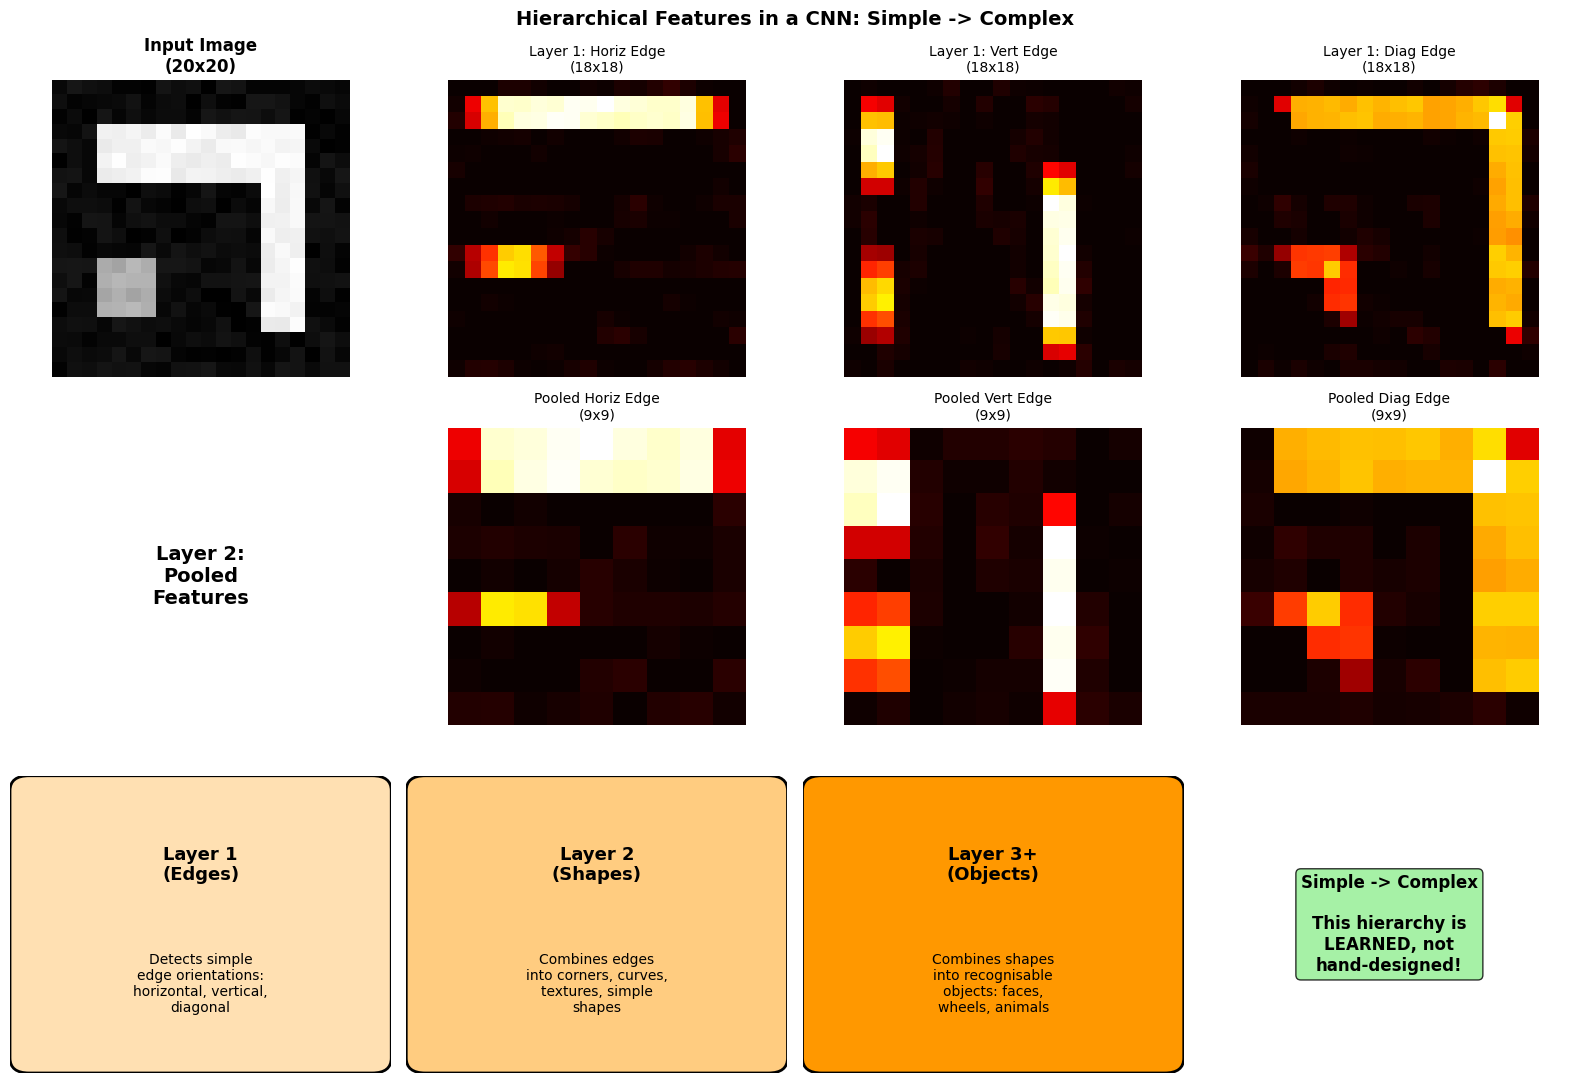

CNNs learn features in a hierarchy:
  Layer 1: Simple edges and gradients
  Layer 2: Combinations of edges -> corners, textures
  Layer 3+: Combinations of shapes -> object parts, objects

This mirrors how the brain processes visual information!


In [23]:
# ============================================================
# C.7  Simulate hierarchical features in a CNN
# ============================================================

# Create a simple image to process through layers
np.random.seed(42)
hier_image = np.zeros((20, 20))

# Draw some shapes
# Horizontal rectangle
hier_image[3:7, 3:17] = 1.0
# Vertical rectangle
hier_image[3:17, 14:17] = 1.0
# Small square
hier_image[12:16, 3:7] = 0.7
# Add some noise
hier_image += np.random.rand(20, 20) * 0.1

# Layer 1 filters: Edge detectors
l1_filters = [
    ("Horiz Edge", np.array([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=float)/3),
    ("Vert Edge",  np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=float)/3),
    ("Diag Edge",  np.array([[0,-1,-1],[1,0,-1],[1,1,0]], dtype=float)/3),
]

# Apply Layer 1
l1_outputs = []
for name, filt in l1_filters:
    out = relu(conv2d(hier_image, filt))
    l1_outputs.append((name, out))

# Layer 2: Combine layer 1 features (simulate by pooling + combining)
l2_outputs = []
for name, out in l1_outputs:
    pooled = max_pool2d(out, 2, 2)
    l2_outputs.append((f"Pooled {name}", pooled))

fig, axes = plt.subplots(3, 4, figsize=(16, 11))

# Row 1: Input + Layer 1 outputs
axes[0, 0].imshow(hier_image, cmap="gray")
axes[0, 0].set_title("Input Image\n(20x20)", fontweight="bold")
axes[0, 0].axis("off")

for idx, (name, out) in enumerate(l1_outputs):
    ax = axes[0, idx+1]
    ax.imshow(out, cmap="hot")
    ax.set_title(f"Layer 1: {name}\n({out.shape[0]}x{out.shape[1]})", fontsize=10)
    ax.axis("off")

# Row 2: Layer 2 (pooled)
axes[1, 0].text(0.5, 0.5, "Layer 2:\nPooled\nFeatures",
                transform=axes[1, 0].transAxes, ha="center", va="center",
                fontsize=14, fontweight="bold")
axes[1, 0].axis("off")

for idx, (name, out) in enumerate(l2_outputs):
    ax = axes[1, idx+1]
    ax.imshow(out, cmap="hot")
    ax.set_title(f"{name}\n({out.shape[0]}x{out.shape[1]})", fontsize=10)
    ax.axis("off")

# Row 3: Summary of what each layer captures
layer_names = ["Layer 1\n(Edges)", "Layer 2\n(Shapes)", "Layer 3+\n(Objects)"]
layer_desc = [
    "Detects simple\nedge orientations:\nhorizontal, vertical,\ndiagonal",
    "Combines edges\ninto corners, curves,\ntextures, simple\nshapes",
    "Combines shapes\ninto recognisable\nobjects: faces,\nwheels, animals",
]
layer_colors = ["#FFE0B2", "#FFCC80", "#FF9800"]

for idx in range(3):
    ax = axes[2, idx]
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.add_patch(patches.FancyBboxPatch((0.05, 0.05), 0.9, 0.9,
                 boxstyle="round,pad=0.05", facecolor=layer_colors[idx],
                 edgecolor="black", linewidth=2))
    ax.text(0.5, 0.7, layer_names[idx], ha="center", va="center",
            fontsize=13, fontweight="bold")
    ax.text(0.5, 0.3, layer_desc[idx], ha="center", va="center",
            fontsize=10)
    ax.axis("off")

axes[2, 3].text(0.5, 0.5, "Simple -> Complex\n\nThis hierarchy is\nLEARNED, not\nhand-designed!",
                ha="center", va="center", fontsize=12, fontweight="bold",
                transform=axes[2, 3].transAxes,
                bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.8))
axes[2, 3].axis("off")

plt.suptitle("Hierarchical Features in a CNN: Simple -> Complex",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("CNNs learn features in a hierarchy:")
print("  Layer 1: Simple edges and gradients")
print("  Layer 2: Combinations of edges -> corners, textures")
print("  Layer 3+: Combinations of shapes -> object parts, objects")
print()
print("This mirrors how the brain processes visual information!")

---
# Part D — Attention in CNNs / Connecting Attention to Vision (Slides + Extended)

## D.1  How Attention Applies to Images

We have now covered:
- **Attention** (Part A-B): A mechanism for dynamically focusing on relevant parts
- **CNNs** (Part C): Neural networks that extract spatial features from images

The natural question is: **Can we combine them?**

Yes! This is exactly what happens in:

1. **Image Captioning** (Show, Attend and Tell): A CNN extracts spatial features
   (e.g., 7x7 grid), and an RNN decoder uses attention to focus on different
   image regions when generating each word of a caption.

2. **Visual Question Answering (VQA)**: Given an image and a question, the model
   attends to relevant image regions to answer the question.

3. **Object Detection**: Attention helps focus on regions likely to contain objects.

### Spatial Attention

In the image domain, attention works over **spatial positions**. Given a CNN
feature map of size $H \times W \times C$ (height x width x channels):

```
CNN Feature Map (7x7x512):

┌───┬───┬───┬───┬───┬───┬───┐
│   │   │   │   │   │   │   │  Each cell is a
├───┼───┼───┼───┼───┼───┼───┤  512-dimensional
│   │   │   │   │   │   │   │  feature vector
├───┼───┼───┼───┼───┼───┼───┤  describing that
│   │   │ * │ * │   │   │   │  region of the
├───┼───┼───┼───┼───┼───┼───┤  image.
│   │   │ * │ * │   │   │   │
├───┼───┼───┼───┼───┼───┼───┤  * = high attention
│   │   │   │   │   │   │   │  (model focuses
├───┼───┼───┼───┼───┼───┼───┤   here)
│   │   │   │   │   │   │   │
├───┼───┼───┼───┼───┼───┼───┤
│   │   │   │   │   │   │   │
└───┴───┴───┴───┴───┴───┴───┘

Attention weight alpha_i for each of the 49 positions.
```

The attention mechanism computes a weight $\alpha_i$ for each spatial position
$i$ (total of $H \times W = 49$ positions), and the context vector is:

$$c = \sum_{i=1}^{49} \alpha_i \cdot f_i$$

where $f_i$ is the feature vector at position $i$.

## D.2  Simulated Spatial Attention on an Image

Let us create an image and simulate what spatial attention looks like when
a model focuses on different regions for different tasks.

In [24]:
# ============================================================
# D.2  Simulate spatial attention on an image
# ============================================================

def create_attention_map(grid_size, focus_row, focus_col, spread=1.0):
    '''
    Create a grid_size x grid_size attention map focused around
    (focus_row, focus_col) with Gaussian-like falloff.
    '''
    attn = np.zeros((grid_size, grid_size))
    for r in range(grid_size):
        for c in range(grid_size):
            dist = (r - focus_row)**2 + (c - focus_col)**2
            attn[r, c] = np.exp(-dist / (2 * spread**2))
    # Normalise to sum to 1
    attn = attn / attn.sum()
    return attn


def upscale_attention(attn_map, target_size=224):
    '''Upscale a small attention map to image size using bilinear-like interpolation.'''
    h, w = attn_map.shape
    scale_h = target_size / h
    scale_w = target_size / w
    result = np.zeros((target_size, target_size))
    for i in range(target_size):
        for j in range(target_size):
            src_r = i / scale_h
            src_c = j / scale_w
            r0, c0 = int(src_r), int(src_c)
            r1 = min(r0 + 1, h - 1)
            c1 = min(c0 + 1, w - 1)
            dr = src_r - r0
            dc = src_c - c0
            result[i, j] = (attn_map[r0, c0] * (1 - dr) * (1 - dc) +
                            attn_map[r1, c0] * dr * (1 - dc) +
                            attn_map[r0, c1] * (1 - dr) * dc +
                            attn_map[r1, c1] * dr * dc)
    return result


# Create a synthetic "scene" image
scene = np.zeros((224, 224, 3))

# Blue sky (top 40%)
scene[:90, :] = [0.53, 0.81, 0.92]

# Green grass (bottom)
scene[150:, :] = [0.13, 0.55, 0.13]

# Transition (middle)
for i in range(90, 150):
    t = (i - 90) / 60.0
    scene[i, :] = [0.53*(1-t) + 0.13*t, 0.81*(1-t) + 0.55*t, 0.92*(1-t) + 0.13*t]

# Brown "dog" blob (center)
scene[100:160, 70:140] = [0.63, 0.32, 0.18]
# Dog "head"
scene[85:110, 90:125] = [0.63, 0.32, 0.18]

# Yellow "ball" (right side)
for i in range(140, 165):
    for j in range(160, 185):
        if (i - 152)**2 + (j - 172)**2 < 13**2:
            scene[i, j] = [1.0, 0.84, 0.0]

# White "cloud" (top left)
for i in range(20, 50):
    for j in range(30, 80):
        if (i - 35)**2 / 15**2 + (j - 55)**2 / 25**2 < 1:
            scene[i, j] = [0.95, 0.95, 0.98]

# Sun (top right)
for i in range(15, 55):
    for j in range(170, 210):
        if (i - 35)**2 + (j - 190)**2 < 18**2:
            scene[i, j] = [1.0, 0.92, 0.23]

scene = np.clip(scene, 0, 1)

print("SPATIAL ATTENTION DEMONSTRATION")
print("=" * 50)
print()
print("We have a synthetic scene with:")
print("  - Sky (blue, top)")
print("  - Cloud (white, top-left)")
print("  - Sun (yellow, top-right)")
print("  - Dog (brown, center)")
print("  - Ball (yellow, right)")
print("  - Grass (green, bottom)")
print()
print("Let's see how attention focuses on different regions")
print("when answering different questions about the image.")

SPATIAL ATTENTION DEMONSTRATION

We have a synthetic scene with:
  - Sky (blue, top)
  - Cloud (white, top-left)
  - Sun (yellow, top-right)
  - Dog (brown, center)
  - Ball (yellow, right)
  - Grass (green, bottom)

Let's see how attention focuses on different regions
when answering different questions about the image.


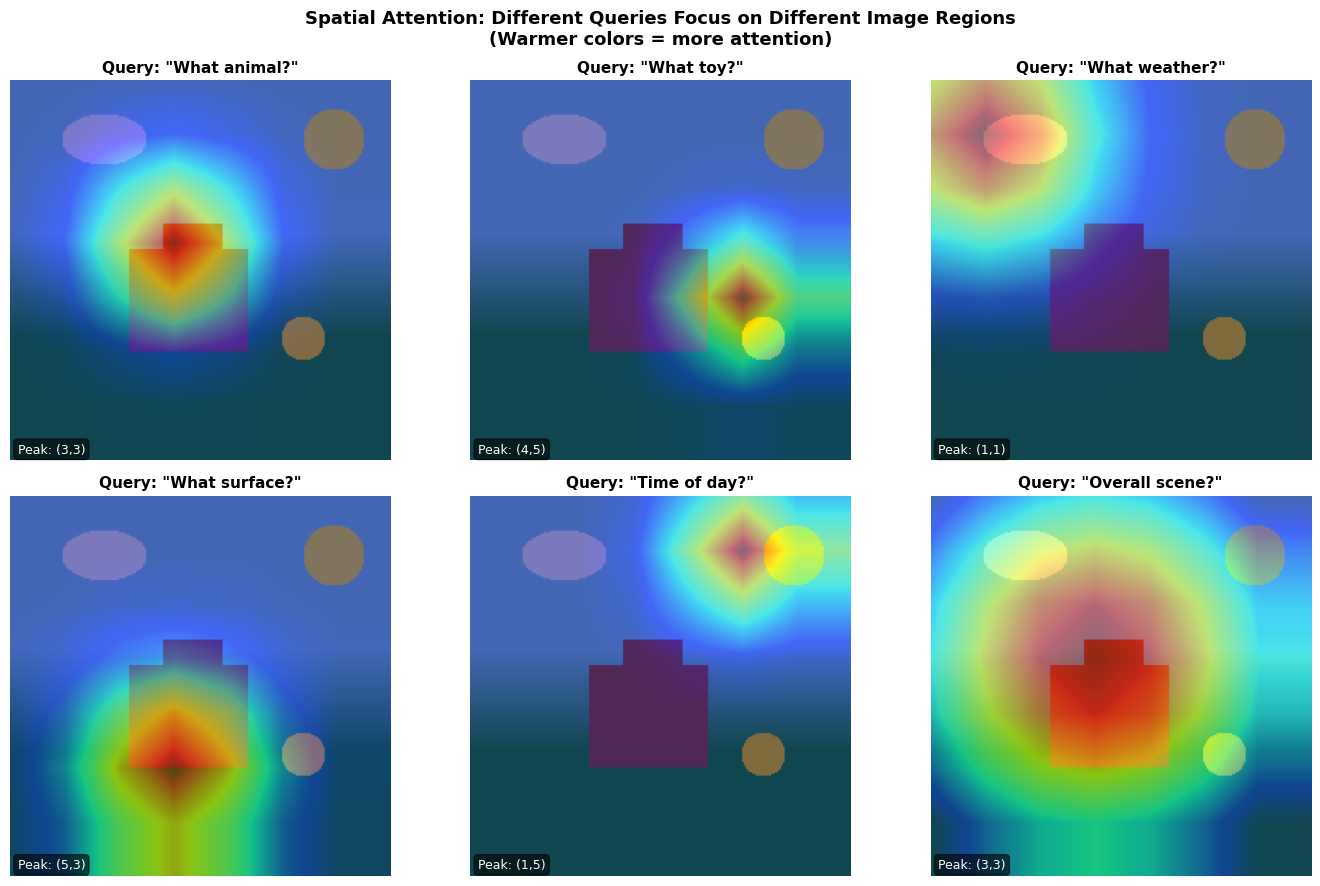

KEY OBSERVATIONS:
  - "What animal?" -> attention focuses on the DOG (center)
  - "What toy?" -> attention focuses on the BALL (right)
  - "What weather?" -> attention focuses on the CLOUD/SKY (top-left)
  - "What surface?" -> attention focuses on the GRASS (bottom)
  - "Time of day?" -> attention focuses on the SUN (top-right)
  - "Overall scene?" -> DIFFUSE attention (looks at everything)

This is how attention in vision works — the model dynamically
decides which spatial regions are relevant for the current task!


In [25]:
# ============================================================
# D.2b  Visualize spatial attention for different queries
# ============================================================

grid_size = 7  # 7x7 attention grid (like a CNN with 7x7 spatial output)

# Different queries focus on different parts of the image
queries = [
    ("What animal?",    3, 3, 1.0),   # Focus on dog (center)
    ("What toy?",       4, 5, 0.8),   # Focus on ball (right)
    ("What weather?",   1, 1, 1.5),   # Focus on sky/cloud (top-left)
    ("What surface?",   5, 3, 1.2),   # Focus on grass (bottom)
    ("Time of day?",    1, 5, 0.9),   # Focus on sun (top-right)
    ("Overall scene?",  3, 3, 3.0),   # Diffuse attention (whole image)
]

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

for idx, (query, fr, fc, spread) in enumerate(queries):
    ax = axes[idx]

    # Show the scene
    ax.imshow(scene)

    # Create and overlay attention map
    attn_map = create_attention_map(grid_size, fr, fc, spread)
    attn_up = upscale_attention(attn_map, 224)
    ax.imshow(attn_up, alpha=0.5, cmap="jet")

    ax.set_title(f'Query: "{query}"', fontsize=11, fontweight="bold")
    ax.axis("off")

    # Show peak attention position
    peak_r, peak_c = np.unravel_index(attn_map.argmax(), attn_map.shape)
    ax.text(0.02, 0.02, f"Peak: ({peak_r},{peak_c})",
            transform=ax.transAxes, fontsize=9, color="white",
            bbox=dict(boxstyle="round", facecolor="black", alpha=0.6))

plt.suptitle("Spatial Attention: Different Queries Focus on Different Image Regions\n"
             "(Warmer colors = more attention)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("KEY OBSERVATIONS:")
print('  - "What animal?" -> attention focuses on the DOG (center)')
print('  - "What toy?" -> attention focuses on the BALL (right)')
print('  - "What weather?" -> attention focuses on the CLOUD/SKY (top-left)')
print('  - "What surface?" -> attention focuses on the GRASS (bottom)')
print('  - "Time of day?" -> attention focuses on the SUN (top-right)')
print('  - "Overall scene?" -> DIFFUSE attention (looks at everything)')
print()
print("This is how attention in vision works — the model dynamically")
print("decides which spatial regions are relevant for the current task!")

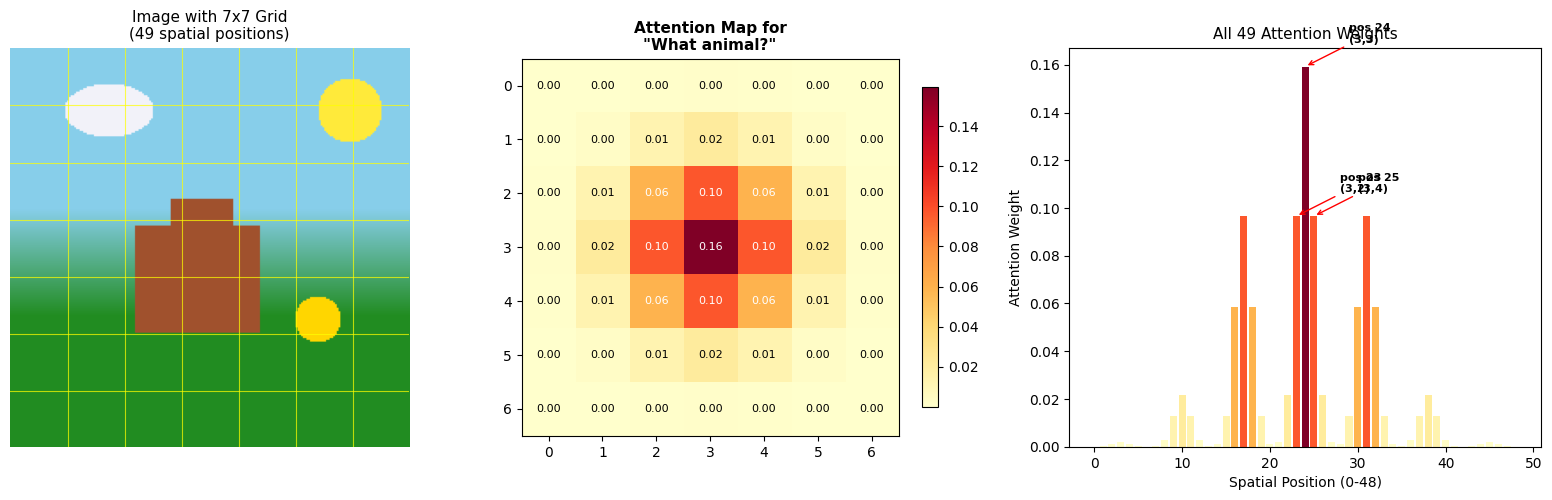

For query 'What animal?':
  Most attended position: 24 (row 3, col 3)
  Top-3 positions: [np.int64(24), np.int64(23), np.int64(25)]
  Sum of all weights: 1.0000 (always 1.0)


In [26]:
# ============================================================
# D.2c  Attention weights as a 7x7 heatmap + bar chart
# ============================================================

# Pick one query for detailed analysis
query_name = "What animal?"
attn_map = create_attention_map(7, 3, 3, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Scene with grid overlay
ax = axes[0]
ax.imshow(scene)
# Draw 7x7 grid
for i in range(1, 7):
    ax.axhline(y=i*32, color="yellow", linewidth=0.8, alpha=0.7)
    ax.axvline(x=i*32, color="yellow", linewidth=0.8, alpha=0.7)
ax.set_title("Image with 7x7 Grid\n(49 spatial positions)", fontsize=11)
ax.axis("off")

# 2. Attention heatmap on 7x7 grid
ax = axes[1]
im = ax.imshow(attn_map, cmap="YlOrRd")
ax.set_title(f'Attention Map for\n"{query_name}"', fontsize=11, fontweight="bold")
ax.set_xticks(range(7))
ax.set_yticks(range(7))
for i in range(7):
    for j in range(7):
        val = attn_map[i, j]
        color = "white" if val > 0.05 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                fontsize=8, color=color)
plt.colorbar(im, ax=ax, shrink=0.8)

# 3. Bar chart of all 49 weights
ax = axes[2]
flat_weights = attn_map.flatten()
colors = plt.cm.YlOrRd(flat_weights / flat_weights.max())
ax.bar(range(49), flat_weights, color=colors)
ax.set_xlabel("Spatial Position (0-48)", fontsize=10)
ax.set_ylabel("Attention Weight", fontsize=10)
ax.set_title("All 49 Attention Weights", fontsize=11)

# Highlight the top-3 positions
top3 = np.argsort(flat_weights)[-3:][::-1]
for pos in top3:
    ax.annotate(f"pos {pos}\n({pos//7},{pos%7})",
                xy=(pos, flat_weights[pos]),
                xytext=(pos + 5, flat_weights[pos] + 0.01),
                fontsize=8, fontweight="bold",
                arrowprops=dict(arrowstyle="->", color="red"))

plt.tight_layout()
plt.show()

print(f"For query '{query_name}':")
print(f"  Most attended position: {top3[0]} (row {top3[0]//7}, col {top3[0]%7})")
print(f"  Top-3 positions: {list(top3)}")
print(f"  Sum of all weights: {flat_weights.sum():.4f} (always 1.0)")

---
# Part E — Summary & Self-Test

## E.1  Complete Architecture Diagrams

### Seq2Seq with Attention (Machine Translation)

```
┌──────────────────────────────────────────────────────────────────────┐
│                    SEQ2SEQ WITH ATTENTION                            │
│                                                                      │
│  SOURCE: "I love machine learning"                                   │
│                                                                      │
│  ENCODER (bi-directional RNN):                                       │
│                                                                      │
│    ──> [RNN] ──> [RNN] ──> [RNN] ──> [RNN]  (forward)              │
│    <── [RNN] <── [RNN] <── [RNN] <── [RNN]  (backward)             │
│          │         │         │         │                             │
│         h_1       h_2       h_3       h_4   (concatenated)          │
│          │         │         │         │                             │
│          +─────────+─────────+─────────+                            │
│                    │                                                 │
│          ┌─────────▼─────────┐                                       │
│          │ ALL hidden states │  (always accessible!)                 │
│          │ available to the  │                                       │
│          │ attention module  │                                       │
│          └─────────┬─────────┘                                       │
│                    │                                                 │
│  DECODER:          │                                                 │
│                    ▼                                                 │
│  For each target word:                                               │
│    1. score_i = f_att(s_{t-1}, h_i)   — alignment scores            │
│    2. alpha_i = softmax(score_i)      — attention weights            │
│    3. c_t = sum(alpha_i * h_i)        — context vector              │
│    4. s_t = g(y_{t-1}, s_{t-1}, c_t)  — new decoder state          │
│    5. y_t = argmax(W * s_t)           — predicted word              │
│                                                                      │
│  TARGET: "J' adore l' apprentissage automatique"                    │
└──────────────────────────────────────────────────────────────────────┘
```

### CNN Architecture

```
┌──────────────────────────────────────────────────────────────────────┐
│                    CONVOLUTIONAL NEURAL NETWORK                      │
│                                                                      │
│  Input: Image (32 x 32 x 3)                                        │
│                                                                      │
│  ┌────────┐   ┌──────┐   ┌────────┐   ┌──────┐   ┌──────┐         │
│  │ CONV   │──>│ ReLU │──>│ CONV   │──>│ ReLU │──>│ POOL │         │
│  │(5x5x6)│   │      │   │(5x5x16)│   │      │   │(2x2) │         │
│  └────────┘   └──────┘   └────────┘   └──────┘   └──────┘         │
│  28x28x6      28x28x6    10x10x16    10x10x16    5x5x16           │
│                                                                      │
│  ┌──────────────────┐                                                │
│  │ FLATTEN           │  5*5*16 = 400                                │
│  └────────┬─────────┘                                                │
│           ▼                                                          │
│  ┌──────────────────┐                                                │
│  │ FC (400 -> 120)  │  Fully connected                              │
│  │ FC (120 -> 84)   │                                                │
│  │ FC (84  -> 10)   │  10 class scores                              │
│  └──────────────────┘                                                │
│                                                                      │
│  Output: [cat: 0.85, dog: 0.10, bird: 0.02, ...]                   │
└──────────────────────────────────────────────────────────────────────┘
```

## E.2  Summary Table — Everything We Covered

### Attention Concepts

| Concept | What it is | Key Formula | Why it matters |
|---------|-----------|-------------|----------------|
| **Alignment Score** | Relevance of encoder position $i$ to decoder step $t$ | $e_{t,i} = f_{att}(s_{t-1}, h_i)$ | Determines where to look |
| **Attention Weight** | Normalised importance (probability) | $\alpha_{t,i} = \text{softmax}(e_{t,i})$ | Sums to 1; interpretable |
| **Context Vector** | Weighted summary of encoder states | $c_t = \sum_i \alpha_{t,i} h_i$ | Replaces the fixed bottleneck |
| **Additive Attention** | Uses a learned neural network | $e = v^T \tanh(W_1 s + W_2 h)$ | First attention (Bahdanau 2014) |
| **Dot-Product Attention** | Simple dot product | $e = s^T h$ | Faster; used in Transformers |
| **Self-Attention** | Sequence attends to itself | Same formulas, Q=K=V from same source | Captures internal relationships |
| **Cross-Attention** | One sequence attends to another | Q from decoder, K/V from encoder | Links encoder and decoder |

### CNN Concepts

| Concept | What it is | Key Formula | Why it matters |
|---------|-----------|-------------|----------------|
| **Convolution** | Sliding filter over image | $\text{out}[i,j] = \sum_{m,n} \text{img}[i+m, j+n] \cdot \text{ker}[m,n]$ | Preserves spatial structure |
| **Filter/Kernel** | Small weight matrix (e.g., 3x3) | Learned during training | Detects specific features |
| **Activation Map** | Output of one filter over entire image | One per filter | Shows where a feature is detected |
| **ReLU** | Activation function | $\max(0, x)$ | Introduces non-linearity |
| **Stride** | How far filter moves each step | Affects output size | Controls downsampling |
| **Padding** | Zeros added around border | Preserves spatial size | Prevents shrinking |
| **Output Size** | Size after convolution | $\lfloor(w + 2p - k) / s\rfloor + 1$ | Essential for architecture design |
| **Max Pooling** | Keep max in each window | $\max(\text{window})$ | Downsamples, adds invariance |
| **Hierarchical Features** | Simple -> complex features | Emergent from stacked layers | Edges -> textures -> objects |

## E.3  Self-Test Questions

Test your understanding with these questions. Click to reveal the answers.

### Attention

1. **What problem does attention solve in Seq2Seq models?**
   <details><summary>Answer</summary>
   Attention solves the <b>bottleneck problem</b>: in a basic Seq2Seq model, all input information is compressed into a single fixed-size context vector. For long inputs, this loses important details. Attention lets the decoder access ALL encoder hidden states at every timestep, dynamically focusing on the most relevant parts.
   </details>

2. **What are the three steps of computing attention?**
   <details><summary>Answer</summary>
   (1) Compute <b>alignment scores</b> between the decoder state and each encoder state (using dot product, additive, or other functions). (2) Apply <b>softmax</b> to get attention weights that sum to 1. (3) Compute the <b>context vector</b> as a weighted sum of encoder states.
   </details>

3. **What is the difference between self-attention and cross-attention?**
   <details><summary>Answer</summary>
   <b>Self-attention</b>: A sequence attends to itself (queries, keys, and values all come from the same sequence). Used to capture relationships within a sentence. <b>Cross-attention</b>: One sequence (decoder) attends to another (encoder). Used to connect encoder and decoder in translation tasks.
   </details>

4. **Why is a bi-directional encoder better for attention?**
   <details><summary>Answer</summary>
   A bi-directional encoder reads the input both forward and backward. This means each hidden state h_i contains information about BOTH the words before AND after position i. This gives the attention mechanism richer representations to work with, since each position summarises its full context.
   </details>

### CNNs

5. **Why do CNNs preserve spatial structure while fully connected layers do not?**
   <details><summary>Answer</summary>
   Fully connected layers flatten the image into a 1D vector, destroying the 2D spatial arrangement of pixels. CNNs use small filters that slide over the image, maintaining the spatial relationships between nearby pixels. The output is still a 2D map.
   </details>

6. **What does the output size formula tell us, and what are all the variables?**
   <details><summary>Answer</summary>
   Formula: w_out = floor((w_in + 2p - k) / s) + 1. Variables: w_in = input size, p = padding, k = kernel/filter size, s = stride. It tells us the spatial size of the output feature map after a convolution. Larger stride or kernel = smaller output. More padding = larger output.
   </details>

7. **Why is ReLU used after convolution?**
   <details><summary>Answer</summary>
   ReLU (max(0, x)) introduces <b>non-linearity</b>. Without an activation function, stacking multiple convolution layers would be equivalent to a single linear transformation (since linear functions composed are still linear). Non-linearity allows the network to learn complex, non-linear patterns.
   </details>

8. **What is max pooling and why is it used?**
   <details><summary>Answer</summary>
   Max pooling takes the maximum value in each window (e.g., 2x2), reducing the spatial size by half. Benefits: (1) Reduces computation in later layers, (2) Reduces overfitting by having fewer parameters, (3) Provides some translation invariance — small shifts in input don't change the max value much.
   </details>

9. **How do CNNs and attention connect in image captioning?**
   <details><summary>Answer</summary>
   A CNN extracts a spatial feature map (e.g., 7x7 grid of feature vectors) from the image. An RNN decoder uses attention over these 49 spatial positions to dynamically focus on different image regions when generating each word of the caption. This is the "Show, Attend and Tell" architecture.
   </details>

10. **What is the hierarchy of features in a CNN?**
    <details><summary>Answer</summary>
    Early layers detect simple features like edges and corners. Middle layers combine these into textures and simple shapes. Deep layers detect complex patterns like object parts and full objects. This hierarchy is LEARNED automatically during training — it is not hand-designed.
    </details>

## E.4  Key Takeaways

1. **Attention is a learned "where to look" mechanism.** It lets a model
   dynamically decide which parts of the input are relevant for the current
   output, rather than compressing everything into a fixed-size vector.

2. **The bottleneck problem** in Seq2Seq models (all info squeezed into one
   vector) is solved by attention, which provides a DIFFERENT context vector
   at each decoder timestep.

3. **Attention has three steps:** compute alignment scores, apply softmax to
   get weights, compute weighted sum to get the context vector.

4. **Additive (Bahdanau) attention** uses a neural network to compute scores;
   **dot-product attention** uses simple dot products (faster, used in Transformers).

5. **CNNs preserve spatial structure** by using small sliding filters instead of
   flattening the image. They learn hierarchical features from edges to objects.

6. **Key CNN operations:** Convolution (feature extraction), ReLU (non-linearity),
   Pooling (downsampling). Output size: $\lfloor(w + 2p - k) / s\rfloor + 1$.

7. **Attention + CNNs** = spatial attention over image regions. This powers
   image captioning, VQA, and many other vision-language tasks.

8. **Everything is differentiable** — attention weights, convolutions, and
   pooling can all be trained end-to-end with backpropagation.

---

### What Comes Next?

In **Lecture 4**, we will see attention applied to image captioning in detail
(the "Show, Attend and Tell" architecture), and later we will study the
**Transformer** — an architecture that uses attention WITHOUT any CNN or RNN!

---

*End of Lecture 3 Companion Notebook*

*CSC5991: Introduction to LLMs — "Attention Is All You Need"*